## Useful code for the data analysis

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from scipy import signal
from scipy.special import erfinv, erf
import glob

def generate_time_array(start_time, end_time, sampling_frequency):
    """
    Generates a time array for the given start and end times with a given sampling frequency.

    Parameters
    ----------
    start_time : float
        The starting time in seconds.
    end_time : float
        The ending time in seconds.
    sampling_frequency : float
        The sampling frequency in Hz.

    Returns
    -------
    np.ndarray
        The generated time array.
    """
    # Calculate the total number of samples
    num_samples = int((end_time - start_time) * sampling_frequency)

    # Generate the time array
    time_array = np.linspace(start_time, end_time, num_samples, endpoint=False)

    return time_array
    
def get_metadata(filename):
    """Gets metadata and does some formatting

    Parameters
    ----------
    filename : str
        Filename of the file to analise

    Returns
    -------
    metadata : dict
        Returns dictionairy containing the metadata of the file
    """

    # gets metadata and does some formatting
    with h5py.File(filename, 'r') as f:
        metadata = {}
        for k, v in f['data'].attrs.items():
            metadata[k] = v
        metadata['datasetShape'] = f['data']['samples'].shape
        metadata['filename'] = os.path.basename(filename)
        metadata['dirname'] = os.path.dirname(filename)
    return metadata    

def get_data(filename:str, columns:list=[0,1,2,3]) -> tuple[np.ndarray, dict]:
    """Gets data from hdf5 file generated by the pxie4492.py or pxi5922.py module

    Parameters
    ----------
    filename : str
        The full file path to the data file
    columns : list
        Containing which data columns need to be taken from the file

    Returns
    ----------
    trace : array
        Array of the data to be analised
    metadata : dict
        A dictionary containing the metadata
    """

    metadata = get_metadata(filename)
    with h5py.File(filename, 'r') as f:
        trace = np.zeros((metadata['datasetShape'][0], 4))
        for idx, col in enumerate(columns):
            trace[:,idx] = f['data']['samples'][:,col].copy()

    return [trace, metadata]

def get_resampled_data(filename: str, columns: list = [0, 1, 2, 3], target_fs: int = 100_000, original_fs: int = 1_000_000) -> tuple[np.ndarray, dict]:
    """Gets data from an HDF5 file generated by the pxie4492.py or pxi5922.py module,
    resamples it from original_fs to target_fs, and ensures the result has 1,000,000 samples.

    Parameters
    ----------
    filename : str
        The full file path to the data file.
    columns : list
        A list specifying which data columns to extract from the file.
    target_fs : int
        The target sampling frequency (default is 100 kHz).
    original_fs : int
        The original sampling frequency (default is 1,000 kHz).

    Returns
    ----------
    trace : np.ndarray
        Array of the data to be analyzed with 1,000,000 samples.
    metadata : dict
        A dictionary containing the metadata.
    """

    # Retrieve metadata from the HDF5 file
    metadata = get_metadata(filename)

    # Open the HDF5 file and read the specified columns into a trace array
    with h5py.File(filename, 'r') as f:
        trace = np.zeros((metadata['datasetShape'][0], len(columns)))  # Adjust the second dimension based on columns
        for idx, col in enumerate(columns):
            trace[:, idx] = f['data']['samples'][:, col].copy()

    # Resample the data for each channel to achieve the desired sample size
    desired_length = 1_000_000  # Set the desired output length
    resampled_trace = np.zeros((desired_length, trace.shape[1]))  # Pre-allocate for resampled trace

    for idx in range(trace.shape[1]):  # Iterate through each channel
        # Resample the signal directly to the desired length
        resampled_channel = signal.resample(trace[:, idx], desired_length)
        resampled_trace[:, idx] = resampled_channel

    return [resampled_trace, metadata]
    
def get_gain_offset(trace, metadata, interval=None, print_output=True) -> np.ndarray: 
    """Determines the gain and offset and returns it. if interval is defined, only the values within are used for phase, 
    gain and offset determination

    Parameters
    ----------
    trace : np.ndarray
        The full file path to the data file
    metadata : dict
        Containing which data columns need to be taken from the file
    interval : np.ndarray
        Array containing interval from where to determine the gain offset
    print_output : boolean
        Handle to print output

    Returns
    ----------
    gain_offset : np.ndarray
        Array of the gain offset data
    """

    gain_offset = np.zeros((2,3))
    if isinstance(metadata['Fs'], np.ndarray):
        time_axis = np.arange(0,trace.shape[0]) / metadata['Fs'][0]
    else:
        time_axis = np.arange(0,trace.shape[0]) / metadata['Fs']

    if interval is None:
        idx = np.where(time_axis)
    else:
        idx = np.logical_and(time_axis > interval[0], time_axis < interval[1])
    mean_i = np.zeros(3)
    ampl_i = np.zeros(3)
    for chan in range(3):
        max_i = np.max(trace[idx,chan])
        min_i = np.min(trace[idx,chan])
        mean_i[chan] = (max_i + min_i)/2
        ampl_i[chan]  = (max_i - min_i)/2
    gain_offset[0,:] = 1/(ampl_i/ampl_i[1])
    new_mean = mean_i * gain_offset[0,:]
    gain_offset[1,:] = new_mean - new_mean[1]

    if print_output:
        if interval is None:
            print(f"\n\nGain and offset from {metadata['filename']} between {time_axis[0]:0.2} and {time_axis[-1]:0.2} seconds:")
        else:
            print(f"\n\nGain and offset from {metadata['filename']} between {interval[0]:0.2} and {interval[1]:0.2} seconds:")
        print(f"gain:\t{gain_offset[0,0]:.8E} {gain_offset[0,1]:.8E} {gain_offset[0,2]:.8E}")
        print(f"offset:\t{gain_offset[1,0]:.8E} {gain_offset[1,1]:.8E} {gain_offset[1,2]:.8E}")

    return gain_offset


def scale_trace(trace, gain_offset) -> np.ndarray:
    """Applies scaling to the trace

    Parameters
    ----------
    trace : np.ndarray
        Unscaled traces of the 3 signals from the 3x3 inteferometer
    gain_offset : np.ndarray
        Gain offset data obtained by the getGainOffset function

    Returns
    -------
    scaled_trace : np.ndarray
        Returns the scaled traces in an np array
    """

    # first apply scaling
    scaled_trace = np.zeros(trace.shape)
    for chan in range(3):
        (gain, offset) = gain_offset[:,chan]
        if trace.ndim == 2:
            scaled_trace[:,chan] = (trace[:,chan] * gain) - offset
        elif trace.ndim == 1:
            scaled_trace[chan] = (trace[chan] * gain) - offset

    return scaled_trace

def get_phase(trace, gain_offset) -> np.ndarray:
    """Calculates the phase

    Parameters
    ----------
    trace : np.ndarray
        The raw traces from the 3x3 inteferometer in one numpy nd array
    gain_offset : np.ndarray
        The gain offset values to apply to the raw traces

    Returns
    -------
    phase : np.ndarray
        Returns the phase off the 3 traces from the 3x3 inteferometer
    """

    # apply scaling
    scaled_trace = scale_trace(trace, gain_offset)

    # calculate phase
    numerator = np.sqrt(3) * (scaled_trace[:, 1] - scaled_trace[:, 2])
    denominator =  2 * scaled_trace[:, 0] - (scaled_trace[:, 1] + scaled_trace[:, 2])
    phase = np.arctan2(numerator,denominator)
    phase = np.unwrap(phase)

    return phase


def my_spectrum(x_data, nfft, overlap, window, fs, confidance, dtrend, y=[]):
    """_summary_

    Parameters
    ----------
    x_data : _type_
        _description_
    nfft : _type_
        _description_
    overlap : _type_
        _description_
    window : _type_
        _description_
    fs : _type_
        _description_
    confidance : _type_
        _description_
    dtrend : _type_
        _description_

    Returns
    -------
    p
        A list
    freq_vector : np.ndarray
        An array
    """
    noverlap = overlap
    p = confidance
    n = len(x_data)
    nwind = len(window)

    if n < nwind:
        x_data[nwind+1]=0 # zero padding
        n=nwind

    k = np.fix((n-noverlap)/(nwind-noverlap), out = None)

    index = np.arange(0,nwind)

    kmu = k*np.linalg.norm(window)**2

    if not y.any():
        pxx = np.zeros(nfft)
        pxx2 = np.zeros(nfft)
        sx = np.zeros(nfft) + 1j*np.zeros(nfft) #Check if this is good
        for i in range(1,int(k)+1):
            if dtrend=='linear':
                xw = window*signal.detrend(x_data[index])
            elif dtrend == 'none':
                xw = window*(x_data[index])
            else:
                xw = window*signal.detrend(x_data[index], type='constant')

            index = index + (nwind - noverlap)
            xx = (np.array([np.fft.fft(xw, nfft)])).ravel()
            sx = np.transpose(sx + xx)
            xx = abs(xx)**2
            pxx = pxx + xx
            pxx2 = pxx2 + abs(xx)**2

        if ~np.any(np.any(np.imag(x_data)!=0)):
            if not (nfft % 2 == 0): #Odd
                select = np.arange(0,(nfft+1/2)+1).astype(int)
            else:
                select = np.arange(0,(nfft/2)+1).astype(int)
        else:
            select = np.arange(0, nfft+1).astype(int)

        pxx = pxx[select]
        pxx2 = pxx2[select]
        cpxx = np.zeros(len(pxx))
        if k > 1:
            c = (k*pxx2-abs(pxx)**2)/(k-1)
            c = np.maximum(c, np.zeros_like(pxx))
            cpxx = np.sqrt(c)

        ff = np.sqrt(2)*erfinv(p)
        pxx = pxx/kmu
        pxxc = ff*cpxx/kmu
        sx = sx/kmu
        p = [pxx, pxxc, abs(sx[select])]

    else:
        pxx = np.zeros(nfft)
        pyy = pxx
        pxy = pxx
        pxx2 = pxx
        pyy2 = pxx
        pxy2 = pxx
        sx = np.zeros(nfft)+1j*np.zeros(nfft)
        sy = np.zeros(nfft)+1j*np.zeros(nfft)

        for i in range(1,int(k)+1):
            if dtrend=='linear':
                xw = window*signal.detrend(x_data[index])
                yw = window*signal.detrend(y[index])
            elif dtrend == 'none':
                xw = window*(x_data[index])
                yw = window*(y[index])
            else:
                xw = window*signal.detrend(x_data[index], type='constant')
                yw = window*signal.detrend(y[index], type='constant')

            index = index + (nwind - noverlap)
            xx = (np.array([np.fft.fft(xw, nfft)])).ravel()
            yy = (np.array([np.fft.fft(yw, nfft)])).ravel()
            sx = sx + xx
            sy = sy + yy
            yy2 = abs(yy)**2
            xx2 = abs(xx)**2
            xy  = yy*np.conj(xx)
            pxx = pxx + xx2
            pyy = pyy + yy2
            pxy = pxy + xy
            pxx2 = pxx2 + abs(xx2)**2
            pyy2 = pyy2 + abs(yy2)**2
            pxy2 = pxy2 + xy*np.conj(xy)

        if ~np.any(np.any(np.imag([x_data, y])!=0)):
            if not (nfft % 2 == 0):
                select = np.arange(0,(nfft+1/2)+1).astype(int)
            else:
                select = np.arange(0,(nfft/2)+1).astype(int)
        else:
            select = np.arange(0, nfft+1).astype(int)

        pxx = pxx[select]
        pyy = pyy[select]
        pxy = pxy[select]
        pxx2 = pxx2[select]
        pyy2 = pyy2[select]
        pxy2 = pxy2[select]

        cpxx = np.zeros(len(pxx))
        cpyy = cpxx
        cpxy = cpxx

        if k > 1:
            c = np.maximum((k*pxx2-abs(pxx)**2)/(k-1),np.zeros(len(pxx)))
            cpxx = np.sqrt(c)
            c = np.maximum((k*pyy2-abs(pyy)**2)/(k-1),np.zeros(len(pxx)))
            cpyy = np.sqrt(c)
            c = np.maximum((k*pxy2-abs(pxy)**2)/(k-1),np.zeros(len(pxx)))
            cpxy = np.sqrt(c)

        txy = pxy/pyy
        cxy = (abs(pxy)**2)/(pxx*pyy)

        ff = np.sqrt(2)*erfinv(p)  # Equal-tails.

        pxx = pxx/kmu
        pyy = pyy/kmu
        pxy = pxy/kmu
        pxxc = ff*cpxx/kmu
        pxyc = ff*cpxy/kmu
        pyyc = ff*cpyy/kmu
        sx   = sx/kmu
        sy   = sy/kmu
        p = [pxx, pyy, pxy, txy, cxy, pxxc, pyyc, pxyc, sx[select], sy[select]]

    freq_vector = select  * (fs/ nfft)

    return p, freq_vector

def plot_phase_psd(phase, fs, reference=np.array([])):
    """_summary_

    Parameters
    ----------
    phase : np.ndarray
        The phase data
    fs : float
        the frequency
    visibility : float, optional
        _description_, None by default
    """
    x_data = phase
    nfft = int(fs)
    double_2_single_sided = 2.0
    scale = nfft
    overlap = 1
    confidance = 1
    dtrend = 'linear'
    fspec = fs/2
    fstart = 1
    fcum = fs/2
    nfft = 2**(round(np.log(fs)/np.log(2)))
    window = np.hanning(nfft)
    df = fs/nfft

    [hspec, ff] = my_spectrum(x_data, nfft, overlap, window, fs, confidance, dtrend, reference)

    length = len(hspec[0][:])
    lenspec = round(min(length, (fspec / df + 1)))
    lencum = round(min(length, (fcum / df + 1)))
    lenstart = round(min(length, (fstart / df + 1)))
    scale = nfft
    hspec[0][:] = double_2_single_sided * hspec[0][:] / scale
    hspec[1][:] = double_2_single_sided * hspec[1][:] / scale
    if reference.any():
        hspec[3] = double_2_single_sided * abs(hspec[3]) / scale
    plt.figure()

    plt.semilogx(np.flip(ff)[lenstart-1:lenspec], 10 * np.log10(np.flip(hspec[0])[lenstart-1:lenspec]),
                 color='#E74320', label='PSD', linewidth=0.5)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (dB/Hz)')
    plt.legend()
    plt.grid(which='major', color='#EEEEEE')
    plt.grid(which='minor', color='#EEEEEE')
    plt.xlim(left=ff[1], right=ff[-1])
    plt.title('PSD of the hydrophone')
    plt.show()
    if reference.any():
        plt.semilogx(np.flip(ff)[lenstart-1:lenspec], 10 * np.log10(np.flip(hspec[1])[lenstart-1:lenspec]),
                     color='#E74320', label='PSD Ref', linewidth=0.5)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power ($V^2$dB/Hz)')
        plt.legend()
        plt.grid(which='major', color='#EEEEEE')
        plt.grid(which='minor', color='#EEEEEE')
        plt.xlim(left=ff[1], right=ff[-1])
        plt.title('PSD of the reference hydrophone')
        plt.show()
    if reference.any():
        plt.semilogx(np.flip(ff)[lenstart-1:lenspec], 10 * np.log10(np.flip(hspec[3])[lenstart-1:lenspec]),
                     color='#E74320', label='Transfer function', linewidth=0.5)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude (dB)')
        plt.legend()
        plt.grid(which='major', color='#EEEEEE')
        plt.grid(which='minor', color='#EEEEEE')
        plt.xlim(left=ff[1], right=ff[-1])
        plt.title('Transfer function')
        plt.show()


def plot_comparison_psd(phase1, fs1, phase2, fs2, reference_1=np.array([]), reference_2=np.array([])):
    """
    Plots the PSD of two signals, the PSD of the reference hydrophone of both signals,
    and the transfer function of both signals.

    Parameters
    ----------
    phase1 : np.ndarray
        Phase data of the first signal.
    fs1 : float
        Sampling frequency of the first signal.
    phase2 : np.ndarray
        Phase data of the second signal.
    fs2 : float
        Sampling frequency of the second signal.
    reference_1 : np.ndarray, optional
        Reference data for the first signal for calculating transfer function. Default is an empty array.
    reference_2 : np.ndarray, optional
        Reference data for the second signal for calculating transfer function. Default is an empty array.
    """
    
    def calculate_psd(phase, fs, reference):
        nfft = 2**(round(np.log(fs)/np.log(2)))
        window = np.hanning(nfft)
        overlap = 1
        confidance = 1
        dtrend = 'linear'
        double_2_single_sided = 2.0

        # Call to my_spectrum with reference
        [hspec, ff] = my_spectrum(phase, nfft, overlap, window, fs, confidance, dtrend, reference)

        df = fs / nfft
        length = len(hspec[0][:])
        lenspec = round(min(length, (fs / 2 / df + 1)))
        lenstart = round(min(length, (1 / df + 1)))
        scale = nfft

        # Apply scaling for single-sided spectrum
        hspec[0][:] = double_2_single_sided * hspec[0][:] / scale
        hspec[1][:] = double_2_single_sided * hspec[1][:] / scale

        # Apply scaling to the transfer function component if it exists
        if len(hspec) > 3:
            hspec[3] = double_2_single_sided * abs(hspec[3]) / scale
        
        return hspec, ff, lenstart, lenspec

    # Calculate PSD for both signals
    hspec1, ff1, lenstart1, lenspec1 = calculate_psd(phase1, fs1, reference_1)
    hspec2, ff2, lenstart2, lenspec2 = calculate_psd(phase2, fs2, reference_2)

    # Plot PSD of the hydrophone for both signals
    plt.figure()
    plt.semilogx(np.flip(ff1)[lenstart1-1:lenspec1], 10 * np.log10(np.flip(hspec1[0])[lenstart1-1:lenspec1]),
                 label='PSD before integration', linewidth=0.5, color='blue')
    plt.semilogx(np.flip(ff2)[lenstart2-1:lenspec2], 10 * np.log10(np.flip(hspec2[0])[lenstart2-1:lenspec2]),
                 label='PSD after integration', linewidth=0.5, color='red')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (dB/Hz)')
    plt.legend()
    plt.grid(which='major', color='#EEEEEE')
    plt.grid(which='minor', color='#EEEEEE')
    plt.title('PSD of the Hydrophone')
    plt.show()

    # Plot PSD of the reference hydrophone for both signals (if references exist)
    if reference_1.any() and reference_2.any():
        plt.figure()
        plt.semilogx(np.flip(ff1)[lenstart1-1:lenspec1], 10 * np.log10(np.flip(hspec1[1])[lenstart1-1:lenspec1]),
                     label='Reference Hydrophone Signal 1', linewidth=0.5, color='blue')
        plt.semilogx(np.flip(ff2)[lenstart2-1:lenspec2], 10 * np.log10(np.flip(hspec2[1])[lenstart2-1:lenspec2]),
                     label='Reference Hydrophone Signal 2', linewidth=0.5, color='red')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power ($V^2$dB/Hz)')
        plt.legend()
        plt.grid(which='major', color='#EEEEEE')
        plt.grid(which='minor', color='#EEEEEE')
        plt.title('PSD of the Reference Hydrophone')
        plt.show()

        # Plot transfer function for both signals (if references and valid transfer function data exist)
        if len(hspec1) > 3 and len(hspec2) > 3:
            plt.figure()
            plt.semilogx(np.flip(ff1)[lenstart1-1:lenspec1], 10 * np.log10(np.flip(abs(hspec1[3]))[lenstart1-1:lenspec1]),
                         label='Transfer Function Signal 1', linewidth=0.5, color='blue')
            plt.semilogx(np.flip(ff2)[lenstart2-1:lenspec2], 10 * np.log10(np.flip(abs(hspec2[3]))[lenstart2-1:lenspec2]),
                         label='Transfer Function Signal 2', linewidth=0.5, color='red')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude (dB)')
            plt.legend()
            plt.grid(which='major', color='#EEEEEE')
            plt.grid(which='minor', color='#EEEEEE')
            plt.title('Transfer Function')
            plt.show()

def plot_transfer_functions_multiple_signals(phases, fs, references, labels, colors):
    """
    Plots the transfer function between multiple signals and their references within the frequency range of 8 kHz to 25 kHz.

    Parameters
    ----------
    phases : list of np.ndarray
        List of phase data for multiple signals.
    fs : float
        Sampling frequency for all signals.
    references : list of np.ndarray
        List of reference data for each signal.
    labels : list of str
        List of labels for each signal, to be used in the plot legend.
    colors : list of str
        List of colors to use for each signal's transfer function plot.
    """
    
    def calculate_psd(phase, fs, reference):
        nfft = 2**(round(np.log(fs)/np.log(2)))
        window = np.hanning(nfft)
        overlap = 1
        confidance = 1
        dtrend = 'linear'
        double_2_single_sided = 2.0

        # Call to my_spectrum with reference
        [hspec, ff] = my_spectrum(phase, nfft, overlap, window, fs, confidance, dtrend, reference)

        df = fs / nfft
        length = len(hspec[0][:])
        lenspec = round(min(length, (fs / 2 / df + 1)))
        lenstart = round(min(length, (1 / df + 1)))
        scale = nfft

        # Apply scaling for single-sided spectrum
        hspec[0][:] = double_2_single_sided * hspec[0][:] / scale
        hspec[1][:] = double_2_single_sided * hspec[1][:] / scale

        # Apply scaling to the transfer function component if it exists
        if len(hspec) > 3:
            hspec[3] = double_2_single_sided * abs(hspec[3]) / scale
        
        return hspec, ff, lenstart, lenspec

    plt.figure()

    # Iterate through each signal and plot its transfer function
    for i in range(len(phases)):
        hspec, ff, lenstart, lenspec = calculate_psd(phases[i], fs, references[i])

        # Check if a reference and transfer function data exists
        if references[i].any() and len(hspec) > 3:
            # Set the frequency range for plotting (8 kHz to 25 kHz)
            freq_min = 8000  # 8 kHz
            freq_max = 25000  # 25 kHz

            # Filter the frequencies within the desired range
            idx_range = (ff >= freq_min) & (ff <= freq_max)

            # Plot the transfer function for this signal
            plt.semilogx(ff[idx_range], 10 * np.log10(abs(hspec[3][idx_range])),
                         label=labels[i], linewidth=0.5, color=colors[i])

    # Configure the plot
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.legend()
    plt.grid(which='major', color='#EEEEEE')
    plt.grid(which='minor', color='#EEEEEE')
    plt.title('Transfer Function (8 kHz - 25 kHz)')
    plt.show()
    

def plot_transfer_functions_multiple_signals_normalised(phases, fs, references, labels, colors):
    """
    Plots the transfer function between multiple signals and their references within the frequency range of 8 kHz to 25 kHz.

    Parameters
    ----------
    phases : list of np.ndarray
        List of phase data for multiple signals.
    fs : float
        Sampling frequency for all signals.
    references : list of np.ndarray
        List of reference data for each signal.
    labels : list of str
        List of labels for each signal, to be used in the plot legend.
    colors : list of str
        List of colors to use for each signal's transfer function plot.
    """
    
    def calculate_psd(phase, fs, reference):
        nfft = 2**(round(np.log(fs)/np.log(2)))
        window = np.hanning(nfft)
        overlap = 1
        confidance = 1
        dtrend = 'linear'
        double_2_single_sided = 2.0

        # Call to my_spectrum with reference
        [hspec, ff] = my_spectrum(phase, nfft, overlap, window, fs, confidance, dtrend, reference)

        df = fs / nfft
        length = len(hspec[0][:])
        lenspec = round(min(length, (fs / 2 / df + 1)))
        lenstart = round(min(length, (1 / df + 1)))
        scale = nfft

        # Apply scaling for single-sided spectrum
        hspec[0][:] = double_2_single_sided * hspec[0][:] / scale
        hspec[1][:] = double_2_single_sided * hspec[1][:] / scale

        # Apply scaling to the transfer function component if it exists
        if len(hspec) > 3:
            hspec[3] = double_2_single_sided * abs(hspec[3]) / scale
        
        return hspec, ff, lenstart, lenspec

    plt.figure()

    # Initialize a variable to hold the maximum transfer function value for normalization
    max_amplitude = 0

    # First pass: find the maximum amplitude for normalization
    for i in range(len(phases)):
        hspec, ff, lenstart, lenspec = calculate_psd(phases[i], fs, references[i])

        # Check if a reference and transfer function data exists
        if references[i].any() and len(hspec) > 3:
            freq_min = 5000  # 8 kHz
            freq_max = 25000  # 25 kHz

            idx_range = (ff >= freq_min) & (ff <= freq_max)

            # Find the maximum amplitude in this range
            max_amplitude = max(max_amplitude, np.max(abs(hspec[3][idx_range])))

    # Second pass: plot the normalized transfer functions
    for i in range(len(phases)):
        hspec, ff, lenstart, lenspec = calculate_psd(phases[i], fs, references[i])

        # Check if a reference and transfer function data exists
        if references[i].any() and len(hspec) > 3:
            freq_min = 5000  # 8 kHz
            freq_max = 25000  # 25 kHz

            idx_range = (ff >= freq_min) & (ff <= freq_max)

            # Normalize the transfer function data
            normalized_transfer_function = abs(hspec[3][idx_range]) / max_amplitude

            # Plot the normalized transfer function for this signal
            plt.plot(ff[idx_range], normalized_transfer_function,
                     label=labels[i], linewidth=0.5, color=colors[i])

    # Configure the plot
    plt.xlim(5000, 25000)  # Set x-axis limits from 8 kHz to 25 kHz
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalized Amplitude')  # Updated y-axis label
    plt.legend()
    plt.grid(which='major', color='#EEEEEE')
    plt.grid(which='minor', color='#EEEEEE')
    plt.title('Normalised transfer Function of the Sensor 6 with water')
    plt.show()

def plot_transfer_functions_multiple_signals_normalised2(phases, fs, references, labels, colors):
    """
    Plots the transfer function between multiple signals and their references within the frequency range of 0 kHz to 8 kHz.

    Parameters
    ----------
    phases : list of np.ndarray
        List of phase data for multiple signals.
    fs : float
        Sampling frequency for all signals.
    references : list of np.ndarray
        List of reference data for each signal.
    labels : list of str
        List of labels for each signal, to be used in the plot legend.
    colors : list of str
        List of colors to use for each signal's transfer function plot.
    """
    
    def calculate_psd(phase, fs, reference):
        nfft = 2**(round(np.log(fs)/np.log(2)))
        window = np.hanning(nfft)
        overlap = 1
        confidance = 1
        dtrend = 'linear'
        double_2_single_sided = 2.0

        # Call to my_spectrum with reference
        [hspec, ff] = my_spectrum(phase, nfft, overlap, window, fs, confidance, dtrend, reference)

        df = fs / nfft
        length = len(hspec[0][:])
        lenspec = round(min(length, (fs / 2 / df + 1)))
        lenstart = round(min(length, (1 / df + 1)))
        scale = nfft

        # Apply scaling for single-sided spectrum
        hspec[0][:] = double_2_single_sided * hspec[0][:] / scale
        hspec[1][:] = double_2_single_sided * hspec[1][:] / scale

        # Apply scaling to the transfer function component if it exists
        if len(hspec) > 3:
            hspec[3] = double_2_single_sided * abs(hspec[3]) / scale
        
        return hspec, ff, lenstart, lenspec

    plt.figure()

    # Initialize a variable to hold the maximum transfer function value for normalization
    max_amplitude = 0

    # First pass: find the maximum amplitude for normalization
    for i in range(len(phases)):
        hspec, ff, lenstart, lenspec = calculate_psd(phases[i], fs, references[i])

        # Check if a reference and transfer function data exists
        if references[i].any() and len(hspec) > 3:
            freq_min = 0  # 0 kHz
            freq_max = 8000  # 8 kHz

            idx_range = (ff >= freq_min) & (ff <= freq_max)

            # Find the maximum amplitude in this range
            max_amplitude = max(max_amplitude, np.max(abs(hspec[3][idx_range])))

    # Second pass: plot the normalized transfer functions
    for i in range(len(phases)):
        hspec, ff, lenstart, lenspec = calculate_psd(phases[i], fs, references[i])

        # Check if a reference and transfer function data exists
        if references[i].any() and len(hspec) > 3:
            freq_min = 0  # 0 kHz
            freq_max = 8000  # 8 kHz

            idx_range = (ff >= freq_min) & (ff <= freq_max)

            # Normalize the transfer function data
            normalized_transfer_function = abs(hspec[3][idx_range]) / max_amplitude

            # Plot the normalized transfer function for this signal
            plt.plot(ff[idx_range], normalized_transfer_function,
                     label=labels[i], linewidth=0.5, color=colors[i])

    # Configure the plot
    plt.xlim(0, 8000)  # Set x-axis limits from 0 kHz to 8 kHz
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalized Amplitude')  # Updated y-axis label
    plt.legend()
    plt.grid(which='major', color='#EEEEEE')
    plt.grid(which='minor', color='#EEEEEE')
    plt.title('Transfer Function (0 kHz - 8 kHz)')
    plt.show()

def plot_transfer_functions_complete(
    phases_1_10kHz, phases_8_25kHz, fs_1_10kHz, fs_8_25kHz, references_1_10kHz, references_8_25kHz, labels, colors
):
    """
    Plots the transfer function between multiple signals and their references
    within the frequency range of 1 kHz to 25 kHz by merging phase data from two 
    frequency sweeps: 1-10 kHz and 8-25 kHz, and limiting the ranges to 1-8 kHz and 8-25 kHz.

    Parameters
    ----------
    phases_1_10kHz : list of np.ndarray
        List of phase data for multiple signals in the 1-10 kHz range.
    phases_8_25kHz : list of np.ndarray
        List of phase data for multiple signals in the 8-25 kHz range.
    fs_1_10kHz : float
        Sampling frequency for the 1-10 kHz signals.
    fs_8_25kHz : float
        Sampling frequency for the 8-25 kHz signals.
    references_1_10kHz : list of np.ndarray
        List of reference data for each 1-10 kHz signal.
    references_8_25kHz : list of np.ndarray
        List of reference data for each 8-25 kHz signal.
    labels : list of str
        List of labels for each signal, to be used in the plot legend.
    colors : list of str
        List of colors to use for each signal's transfer function plot.
    """
    
    def calculate_psd(phase, fs, reference):
        nfft = 2**(round(np.log(fs)/np.log(2)))
        window = np.hanning(nfft)
        overlap = 1
        confidance = 1
        dtrend = 'linear'
        double_2_single_sided = 2.0

        # Call to my_spectrum with reference
        [hspec, ff] = my_spectrum(phase, nfft, overlap, window, fs, confidance, dtrend, reference)

        df = fs / nfft
        length = len(hspec[0][:])
        lenspec = round(min(length, (fs / 2 / df + 1)))
        lenstart = round(min(length, (1 / df + 1)))
        scale = nfft

        # Apply scaling for single-sided spectrum
        hspec[0][:] = double_2_single_sided * hspec[0][:] / scale
        hspec[1][:] = double_2_single_sided * hspec[1][:] / scale

        # Apply scaling to the transfer function component if it exists
        if len(hspec) > 3:
            hspec[3] = double_2_single_sided * abs(hspec[3]) / scale
        
        return hspec, ff, lenstart, lenspec

    plt.figure()

    # Initialize a variable to hold the maximum transfer function value for normalization
    max_amplitude = 0
    combined_transfer_functions = []

    # Single pass: calculate transfer functions, find max amplitude, and prepare for plotting
    for i in range(len(phases_1_10kHz)):
        # Calculate PSD for 1-10 kHz and 8-25 kHz phases
        hspec_1_10kHz, ff_1_10kHz, _, _ = calculate_psd(phases_1_10kHz[i], fs_1_10kHz, references_1_10kHz[i])
        hspec_8_25kHz, ff_8_25kHz, _, _ = calculate_psd(phases_8_25kHz[i], fs_8_25kHz, references_8_25kHz[i])

        # Filter the frequency ranges: 1-8 kHz and 8-25 kHz
        idx_1_8kHz = (ff_1_10kHz >= 100) & (ff_1_10kHz <= 8000)
        idx_8_25kHz = (ff_8_25kHz >= 8000) & (ff_8_25kHz <= 25000)

        # Combine the transfer function and frequency ranges
        ff_combined = np.concatenate((ff_1_10kHz[idx_1_8kHz], ff_8_25kHz[idx_8_25kHz]))
        transfer_function_combined = np.concatenate((hspec_1_10kHz[3][idx_1_8kHz], hspec_8_25kHz[3][idx_8_25kHz]))

        # Find the maximum amplitude in this combined range
        max_amplitude = max(max_amplitude, np.max(abs(transfer_function_combined)))

        # Store combined transfer function and frequency for later plotting
        combined_transfer_functions.append((ff_combined, transfer_function_combined))

    # Now plot all transfer functions normalized by the max amplitude
    for i in range(len(combined_transfer_functions)):
        ff_combined, transfer_function_combined = combined_transfer_functions[i]

        # Normalize the combined transfer function
        normalized_transfer_function = abs(transfer_function_combined) / max_amplitude

        # Plot the normalized transfer function for this signal
        plt.plot(ff_combined, normalized_transfer_function, label=labels[i], linewidth=0.5, color=colors[i])

    # Configure the plot
    plt.xlim(100, 25000)  # Set x-axis limits from 1 kHz to 25 kHz
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalized Amplitude')
    plt.legend()
    plt.grid(which='major', color='#EEEEEE')
    plt.grid(which='minor', color='#EEEEEE')
    plt.title('Normalised transfer Function of sensor 672')
    plt.show()

def process_calibration(file_path):
    # Extraction of the data from the file
    trace_calib, metadata_calib = get_data(file_path)
    
    # Generate time array
    time = generate_time_array(0, 10, metadata_calib['Fs'][0])

    # Plotting the photodiode outputs
    plt.figure(figsize=(10, 6))
    plt.plot(time, trace_calib[:,0], label='Photodiode 1 Voltage')
    plt.plot(time, trace_calib[:,1], label='Photodiode 2 Voltage')
    plt.plot(time, trace_calib[:,2], label='Photodiode 3 Voltage')
    plt.title('Photodiode Voltage over Time')
    plt.xticks(np.linspace(0, 10, 21))
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Ask the user for the calibration window
    try:
        start_time = float(input("Enter the start time of the calibration window: "))
        end_time = float(input("Enter the end time of the calibration window: "))
    except ValueError:
        print("Invalid input! Please enter numeric values for the calibration window.")
        return
    
    # Create the calibration window from user input
    calib_window = np.array([start_time, end_time])

    # Getting the gain offset from the calibration on the user-defined interval (calib_window)
    gain_offset_calib = get_gain_offset(trace_calib, metadata_calib, calib_window)
    phase_calib = get_phase(trace_calib, gain_offset_calib)

    # Plotting phase calibration
    plt.figure(figsize=(10, 6))
    plt.plot(time, phase_calib)
    plt.title('Phase Calibration over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Phase (Radians)')
    plt.grid(True)
    plt.show()
    return gain_offset_calib

def plot_transfer_multiple_files(folder_path, file_prefix, gain_offset_calib):
    """
    Plots the PSD, PSD Ref, and Transfer Function for multiple files with a given prefix.
    
    Parameters
    ----------
    folder_path : str
        The path to the folder containing the files.
    file_prefix : str
        The prefix of the filenames to process.
    gain_offset_calib : np.ndarray
        The gain offset calibration data.
    """
    
    # Create separate figures for each plot type
    plt.figure(figsize=(12, 8))
    fig_psd = plt.figure(figsize=(12, 8))
    fig_psd_ref = plt.figure(figsize=(12, 8))
    fig_transfer = plt.figure(figsize=(12, 8))

    for filename in os.listdir(folder_path):
        if filename.startswith(file_prefix) and filename.endswith('.hdf5'):
            file_path = os.path.join(folder_path, filename)
            
            # Extract data
            trace, metadata = get_data(file_path)
            
            # Compute phase
            phase = get_phase(trace, gain_offset_calib)
            
            # Compute PSD and transfer function
            nfft = int(metadata['Fs'][0])
            double_2_single_sided = 2.0
            overlap = 1
            confidance = 1
            dtrend = 'linear'
            fspec = metadata['Fs'][0] / 2
            fstart = 1
            fcum = metadata['Fs'][0] / 2
            nfft = 2**(round(np.log(metadata['Fs'][0]) / np.log(2)))
            window = np.hanning(nfft)
            df = metadata['Fs'][0] / nfft

            # Pass trace[:,3] as reference
            hspec, ff = my_spectrum(phase, nfft, overlap, window, metadata['Fs'][0], confidance, dtrend, trace[:,3])
            
            length = len(hspec[0])
            lenspec = round(min(length, (fspec / df + 1)))
            lencum = round(min(length, (fcum / df + 1)))
            lenstart = round(min(length, (fstart / df + 1)))
            scale = nfft
            hspec[0] = double_2_single_sided * hspec[0] / scale
            hspec[1] = double_2_single_sided * hspec[1] / scale
            hspec[3] = double_2_single_sided * abs(hspec[3]) / scale

            # Extract the suffix for the legend
            suffix_part = filename.split(file_prefix)[-1]
            suffix = suffix_part.split('deg')[0]  # Stop at 'deg'
            suffix = suffix.replace('.hdf5', '').strip()  # Remove the file extension and any leading/trailing whitespace
            
            # Plotting PSD on fig_psd
            plt.figure(fig_psd.number)
            plt.semilogx(np.flip(ff)[lenstart-1:lenspec], 
                         10 * np.log10(np.flip(hspec[0])[lenstart-1:lenspec]), 
                         label=f'PSD {suffix}°', linewidth=0.5)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power (dB/Hz)')
            plt.legend()
            plt.grid(which='major', color='#EEEEEE')
            plt.grid(which='minor', color='#EEEEEE')
            plt.xlim(left=ff[1], right=ff[-1])
            plt.title('Phase PSD for Files Starting with ' + file_prefix)

            # Plotting PSD Ref on fig_psd_ref
            plt.figure(fig_psd_ref.number)
            plt.semilogx(np.flip(ff)[lenstart-1:lenspec], 
                         10 * np.log10(np.flip(hspec[1])[lenstart-1:lenspec]), 
                         label=f'PSD Ref {suffix}°', linewidth=0.5)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power ($V^2$/Hz)')
            plt.legend()
            plt.grid(which='major', color='#EEEEEE')
            plt.grid(which='minor', color='#EEEEEE')
            plt.xlim(left=ff[1], right=ff[-1])
            plt.title('PSD Ref for Files Starting with ' + file_prefix)

            # Plotting Transfer Function on fig_transfer
            plt.figure(fig_transfer.number)
            plt.semilogx(np.flip(ff)[lenstart-1:lenspec], 
                         10 * np.log10(np.flip(hspec[3])[lenstart-1:lenspec]), 
                         label=f'Transfer Function {suffix}°', linewidth=0.5)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude ($V^2$/Hz)')
            plt.legend()
            plt.grid(which='major', color='#EEEEEE')
            plt.grid(which='minor', color='#EEEEEE')
            plt.xlim(left=ff[1], right=ff[-1])
            plt.title('Transfer Function for Files Starting with ' + file_prefix)

    # Show all three figures
    plt.show()


def plot_multiple_files(folder_path, file_prefix, gain_offset_calib):
    """
    Plots the PSD, PSD Ref, and Transfer Function for multiple files with a given prefix.
    
    Parameters
    ----------
    folder_path : str
        The path to the folder containing the files.
    file_prefix : str
        The prefix of the filenames to process.
    gain_offset_calib : np.ndarray
        The gain offset calibration data.
    """
    
    # Create separate figures for each plot type
    fig_psd = plt.figure(figsize=(12, 8))
    fig_psd_ref = plt.figure(figsize=(12, 8))
    fig_transfer = plt.figure(figsize=(12, 8))

    # Store the plot data to sort later
    psd_data = []
    psd_ref_data = []
    transfer_data = []
    angles = []

    for filename in os.listdir(folder_path):
        if filename.startswith(file_prefix) and filename.endswith('.hdf5'):
            file_path = os.path.join(folder_path, filename)
            
            # Extract data
            trace, metadata = get_data(file_path)
            
            # Compute phase
            phase = get_phase(trace, gain_offset_calib)
            
            # Compute PSD and transfer function
            nfft = int(metadata['Fs'][0])
            double_2_single_sided = 2.0
            overlap = 1
            confidance = 1
            dtrend = 'linear'
            fspec = metadata['Fs'][0] / 2
            fstart = 1
            fcum = metadata['Fs'][0] / 2
            nfft = 2**(round(np.log(metadata['Fs'][0]) / np.log(2)))
            window = np.hanning(nfft)
            df = metadata['Fs'][0] / nfft

            # Pass trace[:,3] as reference
            hspec, ff = my_spectrum(phase, nfft, overlap, window, metadata['Fs'][0], confidance, dtrend, trace[:,3])
            
            length = len(hspec[0])
            lenspec = round(min(length, (fspec / df + 1)))
            lencum = round(min(length, (fcum / df + 1)))
            lenstart = round(min(length, (fstart / df + 1)))
            scale = nfft
            hspec[0] = double_2_single_sided * hspec[0] / scale
            hspec[1] = double_2_single_sided * hspec[1] / scale
            hspec[3] = double_2_single_sided * abs(hspec[3]) / scale

            # Extract the suffix for the legend (angle)
            suffix_part = filename.split(file_prefix)[-1]
            suffix = suffix_part.split('deg')[0].strip()  # Stop at 'deg'
            angle = int(suffix.split('_')[-1])  # Assuming the angle is the last part of the suffix
            
            # Store the angle and corresponding plot data
            angles.append(angle)
            psd_data.append((np.flip(ff)[lenstart-1:lenspec], 10 * np.log10(np.flip(hspec[0])[lenstart-1:lenspec]), f'PSD {angle}°'))
            psd_ref_data.append((np.flip(ff)[lenstart-1:lenspec], 10 * np.log10(np.flip(hspec[1])[lenstart-1:lenspec]), f'PSD Ref {angle}°'))
            transfer_data.append((np.flip(ff)[lenstart-1:lenspec], 10 * np.log10(np.flip(hspec[3])[lenstart-1:lenspec]), f'Transfer Function {angle}°'))

    # Sort the data by angles
    sorted_indices = sorted(range(len(angles)), key=lambda i: angles[i])

    # Generate a colormap where larger angles correspond to darker shades
    cmap = plt.cm.get_cmap('viridis', len(angles))
    
    # Plotting PSD on fig_psd
    plt.figure(fig_psd.number)
    for i, idx in enumerate(sorted_indices):
        plt.semilogx(psd_data[idx][0], psd_data[idx][1], color=cmap(i / len(angles)), label=psd_data[idx][2], linewidth=0.5)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (dB/Hz)')
    plt.legend()
    plt.grid(which='major', color='#EEEEEE')
    plt.grid(which='minor', color='#EEEEEE')
    plt.xlim(left=ff[1], right=10E6)
    plt.title('Phase PSD for Files Starting with ' + file_prefix)

    # Plotting PSD Ref on fig_psd_ref
    plt.figure(fig_psd_ref.number)
    for i, idx in enumerate(sorted_indices):
        plt.semilogx(psd_ref_data[idx][0], psd_ref_data[idx][1], color=cmap(i / len(angles)), label=psd_ref_data[idx][2], linewidth=0.5)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power ($V^2$/Hz)')
    plt.legend()
    plt.grid(which='major', color='#EEEEEE')
    plt.grid(which='minor', color='#EEEEEE')
    plt.xlim(left=ff[1], right=10E6)
    plt.title('PSD Ref for Files Starting with ' + file_prefix)

    # Plotting Transfer Function on fig_transfer
    plt.figure(fig_transfer.number)
    for i, idx in enumerate(sorted_indices):
        plt.semilogx(transfer_data[idx][0], transfer_data[idx][1], color=cmap(i / len(angles)), label=transfer_data[idx][2], linewidth=0.5)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude ($V^2$/Hz)')
    plt.legend()
    plt.grid(which='major', color='#EEEEEE')
    plt.grid(which='minor', color='#EEEEEE')
    plt.xlim(left=ff[1], right=10E6)
    plt.title('Transfer Function for Files Starting with ' + file_prefix)

    # Show all three figures
    plt.show()

## Calibration sensor 1D

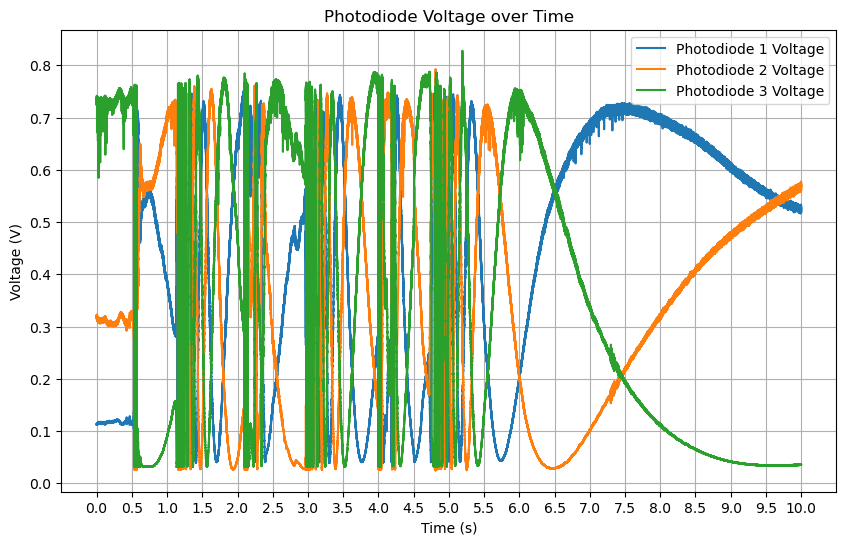

Enter the start time of the calibration window:  3
Enter the end time of the calibration window:  3.5




Gain and offset from 20240902_sensor1D_calibration_badrand.hdf5 between 3.0 and 3.5 seconds:
gain:	1.02325906E+00 1.00000000E+00 9.77481711E-01
offset:	1.40861375E-02 0.00000000E+00 4.59724548E-03


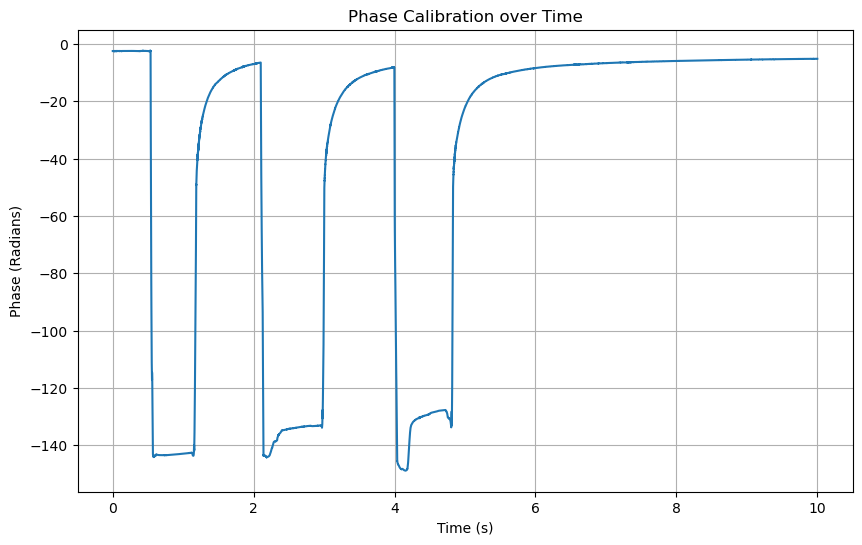

In [18]:
## Here we apply the calibration

gain_offset_calib_1D = process_calibration(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_calibration_badrand.hdf5')

### Sensor 1D

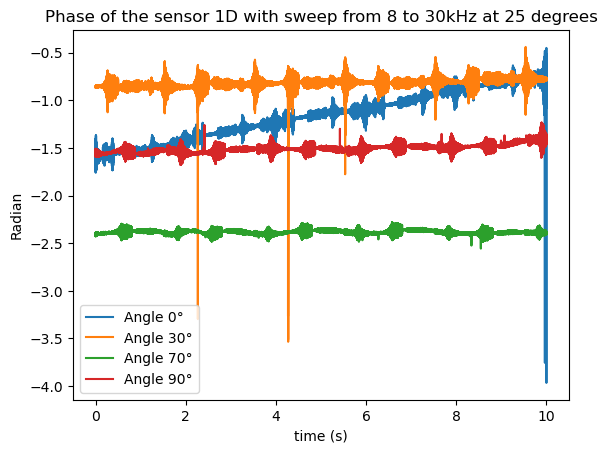

C:\Users\mugniersnm\AppData\Local\Temp\ipykernel_12124\293211693.py:391: RuntimeWarning: invalid value encountered in multiply
  pxyc = ff*cpxy/kmu
C:\Users\mugniersnm\AppData\Local\Temp\ipykernel_12124\293211693.py:391: RuntimeWarning: invalid value encountered in divide
  pxyc = ff*cpxy/kmu


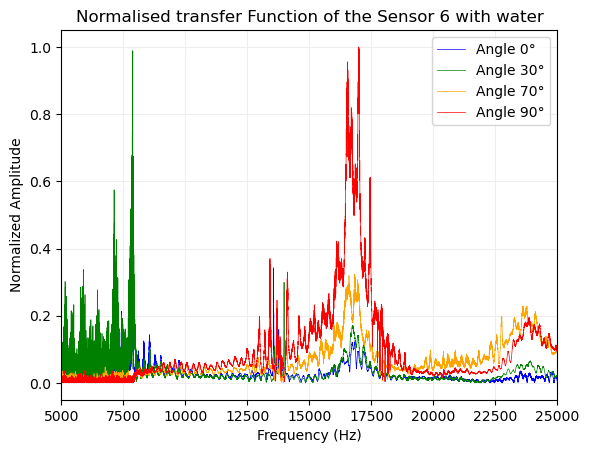

In [51]:
# Applying the calibration to real data

## Extraction of the data sweep 8_25 kHz
[trace_1D_0, metadata_1D_0] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_swp_1_30kHz_0deg_1Vpp.hdf5')
[trace_1D_30, metadata_1D_30] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_swp_8_25kHz_30deg_1Vpp.hdf5')
[trace_1D_70, metadata_1D_60] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_swp_8_25kHz_70deg_200mVpp.hdf5')
[trace_1D_90, metadata_1D_90] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_swp_8_25kHz_90deg_200mVpp.hdf5')


[trace_1D_noise, metadata_1D_noise] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_ruis_badrand.hdf5')
## Plotting 0°
time = generate_time_array(0, 10, metadata_1D_0['Fs'][0])
phase_1D_0 = get_phase(trace_1D_0, gain_offset_calib_1D)
phase_1D_30 = get_phase(trace_1D_30, gain_offset_calib_1D)
phase_1D_70 = get_phase(trace_1D_70, gain_offset_calib_1D)
phase_1D_90 = get_phase(trace_1D_90, gain_offset_calib_1D)

phase_noise = get_phase(trace_1D_noise, gain_offset_calib_1D)

plt.plot(time, phase_1D_0, label="Angle 0°")
plt.plot(time, phase_1D_30, label="Angle 30°")
plt.plot(time, phase_1D_70, label="Angle 70°")
plt.plot(time, phase_1D_90, label="Angle 90°")


plt.legend()
plt.title('Phase of the sensor 1D with sweep from 8 to 30kHz at 25 degrees')
plt.xlabel('time (s)')
plt.ylabel('Radian')
plt.show()
## Plotting the PSD and the transfer function

# plot_phase_psd(phase, metadata_1D['Fs'][0], trace_1D[:,3])
plot_transfer_functions_multiple_signals_normalised([phase_1D_0, phase_1D_30, phase_1D_70, phase_1D_90], metadata_1D_0['Fs'][0], [trace_1D_0[:,3], trace_1D_30[:,3], trace_1D_70[:,3], trace_1D_90[:,3]], ['Angle 0°', 'Angle 30°','Angle 70°','Angle 90°'], ['blue', 'green','orange','red'])


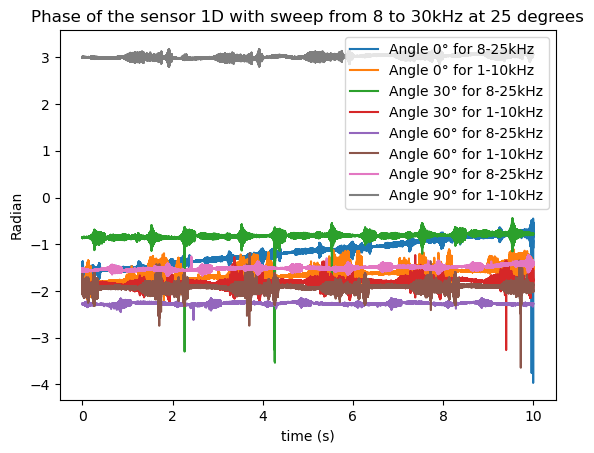

C:\Users\mugniersnm\AppData\Local\Temp\ipykernel_12124\293211693.py:391: RuntimeWarning: invalid value encountered in multiply
  pxyc = ff*cpxy/kmu
C:\Users\mugniersnm\AppData\Local\Temp\ipykernel_12124\293211693.py:391: RuntimeWarning: invalid value encountered in divide
  pxyc = ff*cpxy/kmu


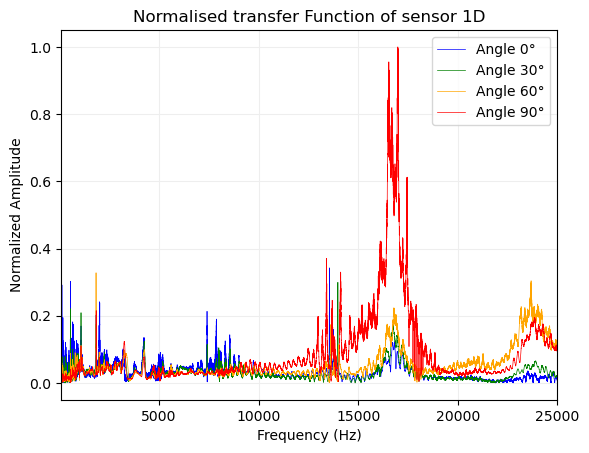

In [52]:
# Applying the calibration to real data

## Extraction of the data for both sweeps
[trace_1D_0_8_25, metadata_1D_0_8_25] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_swp_1_30kHz_0deg_1Vpp.hdf5')
[trace_1D_0_1_10, metadata_1D_0_1_10] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_swp_1_10kHz_0deg_3Vpp.hdf5')

[trace_1D_30_8_25, metadata_1D_30_8_25] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_swp_8_25kHz_30deg_1Vpp.hdf5')
[trace_1D_30_1_10, metadata_1D_30_1_10] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_swp_1_10kHz_30deg_2Vpp.hdf5')

[trace_1D_60_8_25, metadata_1D_60_8_25] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_swp_8_25kHz_60deg_200mVpp.hdf5')
[trace_1D_60_1_10, metadata_1D_60_1_10] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_swp_1_10kHz_60deg_2Vpp.hdf5')

[trace_1D_90_8_25, metadata_1D_90_8_25] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_swp_8_25kHz_90deg_200mVpp.hdf5')
[trace_1D_90_1_10, metadata_1D_90_1_10] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_swp_1_10kHz_90deg_1Vpp.hdf5')

## Plotting
time = generate_time_array(0, 10, 100000)
phase_1D_0_8_25 = get_phase(trace_1D_0_8_25, gain_offset_calib_1D)
phase_1D_0_1_10 = get_phase(trace_1D_0_1_10, gain_offset_calib_1D)

phase_1D_30_8_25 = get_phase(trace_1D_30_8_25, gain_offset_calib_1D)
phase_1D_30_1_10 = get_phase(trace_1D_30_1_10, gain_offset_calib_1D)

phase_1D_60_8_25 = get_phase(trace_1D_60_8_25, gain_offset_calib_1D)
phase_1D_60_1_10 = get_phase(trace_1D_60_1_10, gain_offset_calib_1D)

phase_1D_90_8_25 = get_phase(trace_1D_90_8_25, gain_offset_calib_1D)
phase_1D_90_1_10 = get_phase(trace_1D_90_1_10, gain_offset_calib_1D)


plt.plot(time, phase_1D_0_8_25, label="Angle 0° for 8-25kHz")
plt.plot(time, phase_1D_0_1_10, label="Angle 0° for 1-10kHz")

plt.plot(time, phase_1D_30_8_25, label="Angle 30° for 8-25kHz")
plt.plot(time, phase_1D_30_1_10, label="Angle 30° for 1-10kHz")

plt.plot(time, phase_1D_60_8_25, label="Angle 60° for 8-25kHz")
plt.plot(time, phase_1D_60_1_10, label="Angle 60° for 1-10kHz")

plt.plot(time, phase_1D_90_8_25, label="Angle 90° for 8-25kHz")
plt.plot(time, phase_1D_90_1_10, label="Angle 90° for 1-10kHz")
plt.legend()
plt.title('Phase of the sensor 1D with sweep from 8 to 30kHz at 25 degrees')
plt.xlabel('time (s)')
plt.ylabel('Radian')
plt.show()
## Plotting the PSD and the transfer function

# plot_phase_psd(phase, metadata_1D['Fs'][0], trace_1D[:,3])
plot_transfer_functions_complete([phase_1D_0_1_10, phase_1D_30_1_10, phase_1D_60_1_10, phase_1D_90_1_10], [phase_1D_0_8_25, phase_1D_30_8_25, phase_1D_60_8_25, phase_1D_90_8_25], 100000, 100000, [trace_1D_0_1_10[:,3], trace_1D_30_1_10[:,3], trace_1D_60_1_10[:,3], trace_1D_90_1_10[:,3]], [trace_1D_0_8_25[:,3], trace_1D_30_8_25[:,3], trace_1D_60_8_25[:,3], trace_1D_90_8_25[:,3]], ['Angle 0°', 'Angle 30°', 'Angle 60°', 'Angle 90°'], ['blue', 'green','orange','red'])


In [20]:
# ## Reshape the trace_1D_noise[:,3] so that it has the same size as the data with a sampling frequency of 1000kHz
# trace_1D_noise_reshape=np.copy(trace_1D_noise[:,3]) ## Copying the noise data

# ## Determining how many zeros to add
# target_size = 10_000_000
# current_size = np.shape(trace_1D_noise_reshape)[0]
# zeros_to_add = target_size - current_size
# # Create a zero array of length zeros_to_add
# zero_padding = np.zeros(zeros_to_add)
# trace_1D_noise_reshape = np.concatenate((trace_1D_noise_reshape, zero_padding))

## Calibration Sensor 6 water

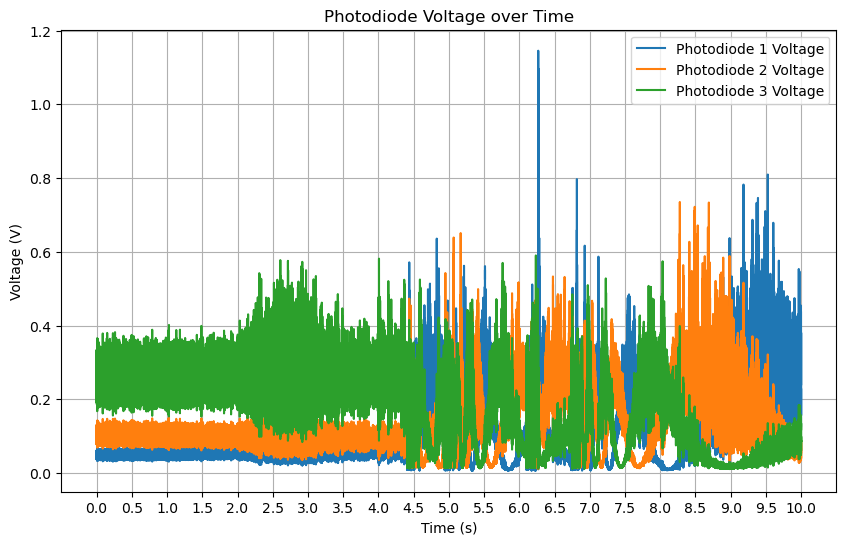

Enter the start time of the calibration window:  6.75
Enter the end time of the calibration window:  7




Gain and offset from 20240830_091026_calibratie_sensor6_inbad.hdf5 between 6.8 and 7.0 seconds:
gain:	5.21371818E-01 1.00000000E+00 8.27962774E-01
offset:	-9.55449310E-03 0.00000000E+00 -3.34163019E-03


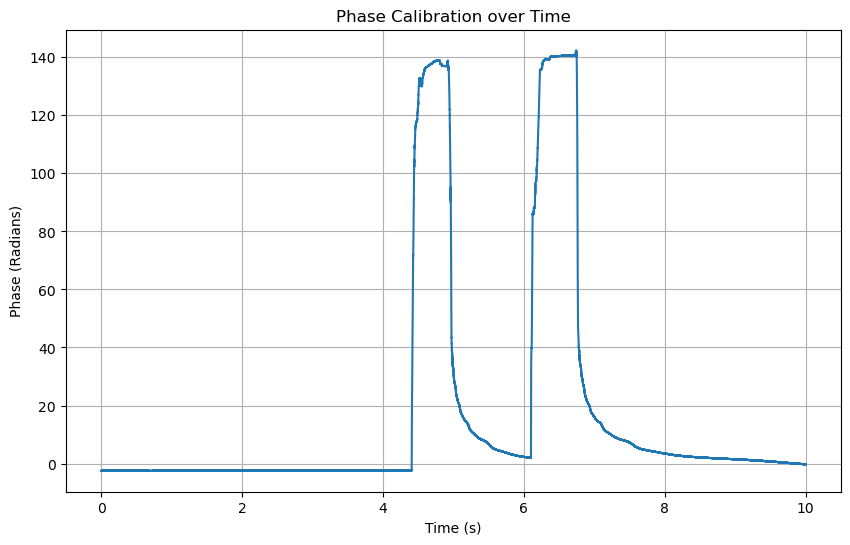

In [3]:
## Here we apply the calibration

gain_offset_calib_6 = process_calibration(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\30082024\20240830_091026_calibratie_sensor6_inbad.hdf5')

## Sensor 6 water

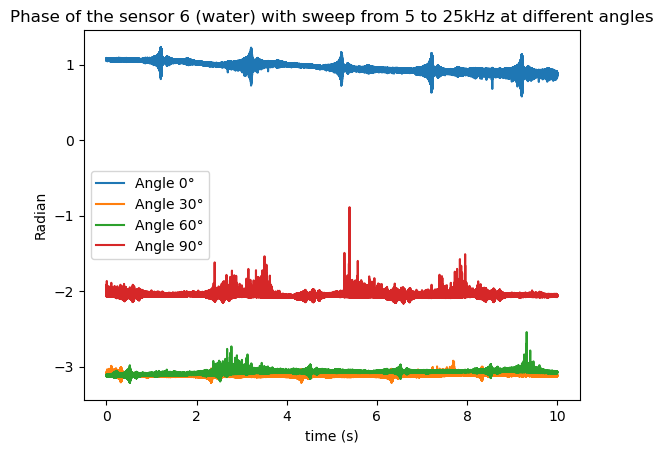

C:\Users\mugniersnm\AppData\Local\Temp\ipykernel_12124\621173234.py:391: RuntimeWarning: invalid value encountered in multiply
  pxyc = ff*cpxy/kmu
C:\Users\mugniersnm\AppData\Local\Temp\ipykernel_12124\621173234.py:391: RuntimeWarning: invalid value encountered in divide
  pxyc = ff*cpxy/kmu


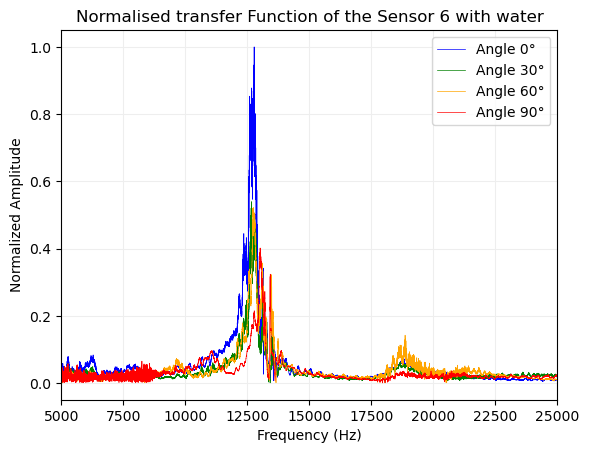

In [35]:
# Applying the calibration to real data

## Extraction of the data
# [trace_6w, metadata_6w] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\30082024\20240830_sensor6_swp_5_25kHz_0deg_Ac_200mVpp.hdf5')
# [trace_6w_noise, metadata_6w_noise] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\30082024\20240830_091122_ruis_sensor6_inbad.hdf5')
# print(np.shape(trace_6w_noise))
# print(np.shape(trace_6w))
# ## Plotting
# time = generate_time_array(0, 10, 100000)
# phase = get_phase(trace_6w, gain_offset_calib_6)
# phase_noise = get_phase(trace_6w_noise, gain_offset_calib_6)

# plt.plot(time, phase)
# plt.title('Phase of the sensor 6 with sweep from 5 to 25kHz at 0 degrees')
# plt.xlabel('time (s)')
# plt.ylabel('Radian')
# plt.show()
# ## Plotting the PSD and the transfer function

# # plot_phase_psd(phase, metadata_1D['Fs'][0], trace_1D[:,3])
# plot_comparison_psd(phase_noise, 100000, phase, 100000, trace_1D_noise[:,3], trace_6w[:,3])

# Applying the calibration to real data

## Extraction of the data
[trace_6w_0, metadata_1D_0] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\30082024\20240830_sensor6_swp_5_25kHz_0deg_Ac_200mVpp.hdf5')
[trace_6w_30, metadata_1D_30] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\30082024\20240830_sensor6_swp_5_25kHz_30deg_Ac_100mVpp.hdf5')
[trace_6w_60, metadata_1D_60] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\30082024\20240830_sensor6_swp_5_25kHz_60deg_Ac_100mVpp.hdf5')
[trace_6w_90, metadata_1D_90] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\30082024\20240830_sensor6_swp_5_25kHz_90deg_Ac_100mVpp.hdf5')


[trace_1D_noise, metadata_1D_noise] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_ruis_badrand.hdf5')
## Plotting 0°
time = generate_time_array(0, 10, metadata_1D_0['Fs'][0])
phase_6w_0 = get_phase(trace_6w_0, gain_offset_calib_6)
phase_6w_30 = get_phase(trace_6w_30, gain_offset_calib_6)
phase_6w_60 = get_phase(trace_6w_60, gain_offset_calib_6)
phase_6w_90 = get_phase(trace_6w_90, gain_offset_calib_6)

# phase_noise = get_phase(trace_1D_noise, gain_offset_calib_6)

plt.plot(time, phase_6w_0, label="Angle 0°")
plt.plot(time, phase_6w_30, label="Angle 30°")
plt.plot(time, phase_6w_60, label="Angle 60°")
plt.plot(time, phase_6w_90, label="Angle 90°")


plt.legend()
plt.title('Phase of the sensor 6 (water) with sweep from 5 to 25kHz at different angles')
plt.xlabel('time (s)')
plt.ylabel('Radian')
plt.show()
## Plotting the PSD and the transfer function

# plot_phase_psd(phase, metadata_1D['Fs'][0], trace_1D[:,3])
plot_transfer_functions_multiple_signals_normalised([phase_6w_0, phase_6w_30, phase_6w_60, phase_6w_90], metadata_1D_0['Fs'][0], [trace_6w_0[:,3], trace_6w_30[:,3], trace_6w_60[:,3], trace_6w_90[:,3]], ['Angle 0°', 'Angle 30°','Angle 60°','Angle 90°'], ['blue', 'green','orange','red'])



## Calibration Sensor 672

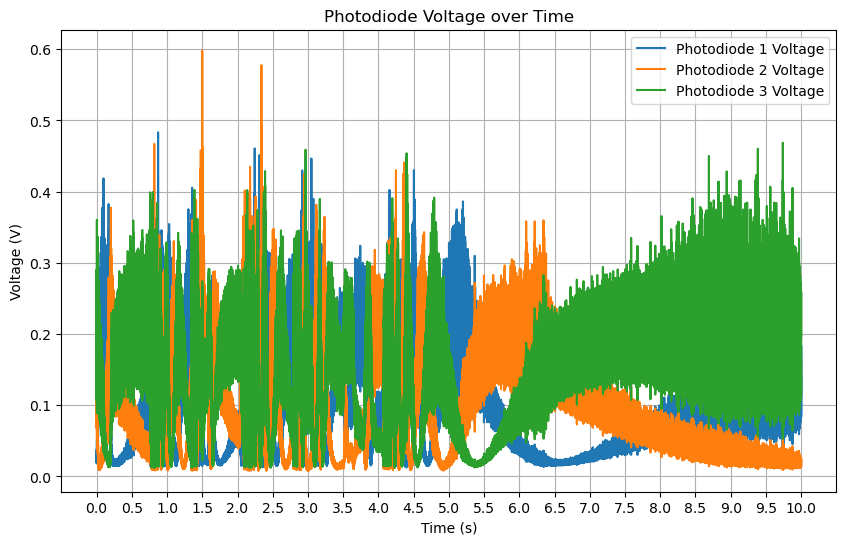

Enter the start time of the calibration window:  4.1
Enter the end time of the calibration window:  4.5




Gain and offset from 20240903_sensor672_calibration_in_bad_at_Fs_1000kHz.hdf5 between 4.1 and 4.5 seconds:
gain:	1.10821119E+00 1.00000000E+00 9.77593335E-01
offset:	5.07996665E-03 0.00000000E+00 2.89626284E-03


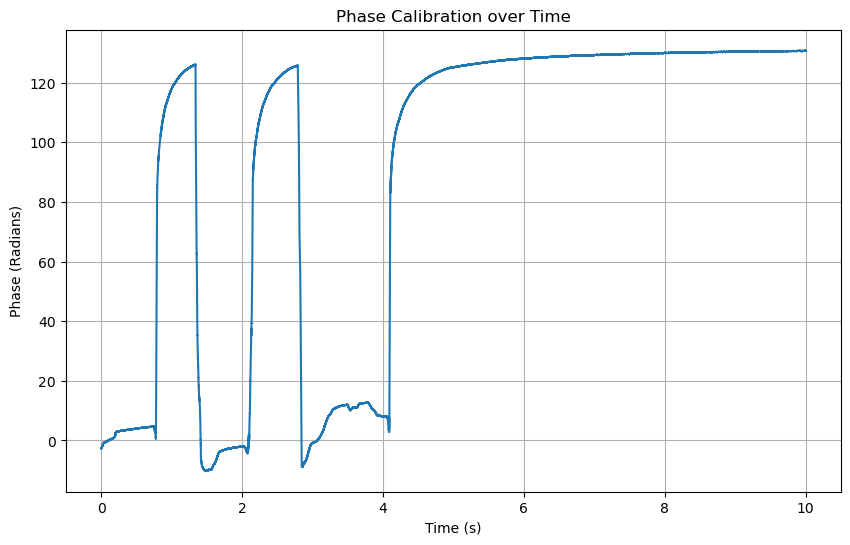

In [2]:
## Here we apply the calibration

gain_offset_calib_672 = process_calibration(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\03092024\20240903_sensor672_calibration_in_bad_at_Fs_1000kHz.hdf5')

## Sensor 672

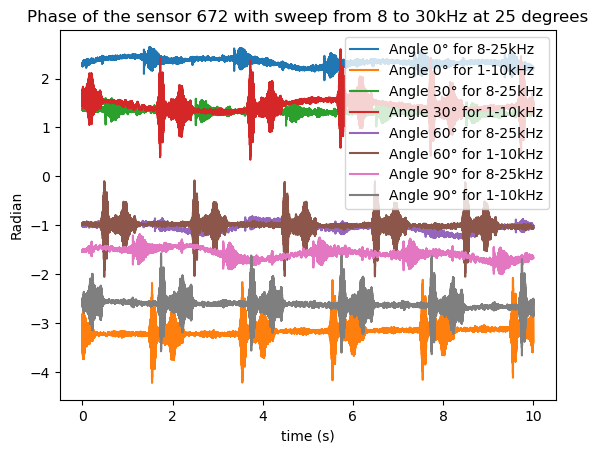

C:\Users\mugniersnm\AppData\Local\Temp\ipykernel_11744\1764329559.py:391: RuntimeWarning: invalid value encountered in multiply
  pxyc = ff*cpxy/kmu
C:\Users\mugniersnm\AppData\Local\Temp\ipykernel_11744\1764329559.py:391: RuntimeWarning: invalid value encountered in divide
  pxyc = ff*cpxy/kmu


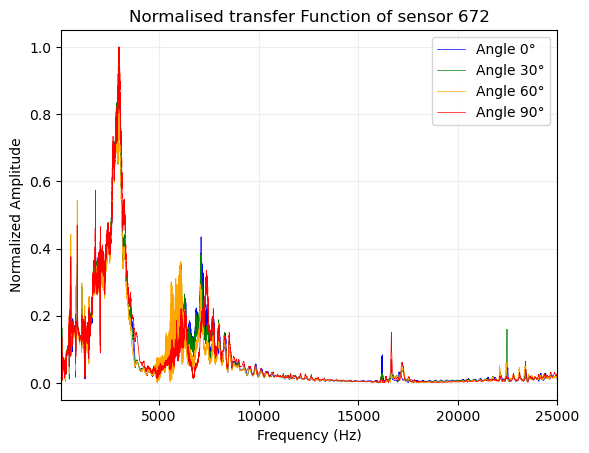

In [4]:

## Extraction of the data for both sweeps
[trace_672_0_8_25, metadata_672_0_8_25] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\03092024_sensor672\20240903_sensor672_swp_8_25kHz_0deg_1Vpp.hdf5')
[trace_672_0_1_10, metadata_672_0_1_10] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\03092024_sensor672\20240903_sensor672_swp_1_10kHz_0deg_100mVpp.hdf5')

[trace_672_30_8_25, metadata_672_30_8_25] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\03092024_sensor672\20240903_sensor672_swp_8_25kHz_30deg_1Vpp.hdf5')
[trace_672_30_1_10, metadata_672_30_1_10] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\03092024_sensor672\20240903_sensor672_swp_1_10kHz_30deg_100mVpp.hdf5')

[trace_672_60_8_25, metadata_672_60_8_25] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\03092024_sensor672\20240903_sensor672_swp_8_25kHz_60deg_500mVpp.hdf5')
[trace_672_60_1_10, metadata_672_60_1_10] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\03092024_sensor672\20240903_sensor672_swp_1_10kHz_60deg_100mVpp.hdf5')

[trace_672_90_8_25, metadata_672_90_8_25] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\03092024_sensor672\20240903_sensor672_swp_8_25kHz_110_1Vpp.hdf5')
[trace_672_90_1_10, metadata_672_90_1_10] = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\03092024_sensor672\20240903_sensor672_swp_1_10kHz_110deg_100mVpp.hdf5')

## Plotting
time = generate_time_array(0, 10, 100000)
phase_672_0_8_25 = get_phase(trace_672_0_8_25, gain_offset_calib_672)
phase_672_0_1_10 = get_phase(trace_672_0_1_10, gain_offset_calib_672)

phase_672_30_8_25 = get_phase(trace_672_30_8_25, gain_offset_calib_672)
phase_672_30_1_10 = get_phase(trace_672_30_1_10, gain_offset_calib_672)

phase_672_60_8_25 = get_phase(trace_672_60_8_25, gain_offset_calib_672)
phase_672_60_1_10 = get_phase(trace_672_60_1_10, gain_offset_calib_672)

phase_672_90_8_25 = get_phase(trace_672_90_8_25, gain_offset_calib_672)
phase_672_90_1_10 = get_phase(trace_672_90_1_10, gain_offset_calib_672)


plt.plot(time, phase_672_0_8_25, label="Angle 0° for 8-25kHz")
plt.plot(time, phase_672_0_1_10, label="Angle 0° for 1-10kHz")

plt.plot(time, phase_672_30_8_25, label="Angle 30° for 8-25kHz")
plt.plot(time, phase_672_30_1_10, label="Angle 30° for 1-10kHz")

plt.plot(time, phase_672_60_8_25, label="Angle 60° for 8-25kHz")
plt.plot(time, phase_672_60_1_10, label="Angle 60° for 1-10kHz")

plt.plot(time, phase_672_90_8_25, label="Angle 90° for 8-25kHz")
plt.plot(time, phase_672_90_1_10, label="Angle 90° for 1-10kHz")
plt.legend()
plt.title('Phase of the sensor 672 with sweep from 8 to 30kHz at 25 degrees')
plt.xlabel('time (s)')
plt.ylabel('Radian')
plt.show()
## Plotting the PSD and the transfer function

# plot_phase_psd(phase, metadata_1D['Fs'][0], trace_1D[:,3])
plot_transfer_functions_complete([phase_672_0_1_10, phase_672_30_1_10, phase_672_60_1_10, phase_672_90_1_10], [phase_672_0_8_25, phase_672_30_8_25, phase_672_60_8_25, phase_672_90_8_25], 100000, 100000, [trace_672_0_1_10[:,3], trace_672_30_1_10[:,3], trace_672_60_1_10[:,3], trace_672_90_1_10[:,3]], [trace_672_0_8_25[:,3], trace_672_30_8_25[:,3], trace_672_60_8_25[:,3], trace_672_90_8_25[:,3]], ['Angle 0°', 'Angle 30°', 'Angle 60°', 'Angle 90°'], ['blue', 'green','orange','red'])




## Calibration for sensor 6 with oil

C:\Users\mugniersnm\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


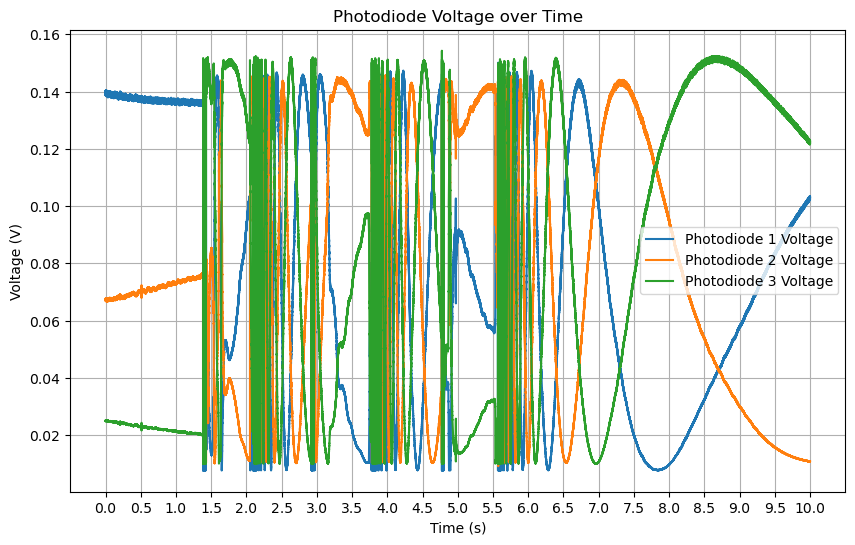

Enter the start time of the calibration window:  3.7
Enter the end time of the calibration window:  4




Gain and offset from 20240904_sensor6_oil_calibration_in_bad_Fs_100kHz.hdf5 between 3.7 and 4.0 seconds:
gain:	9.79378430E-01 1.00000000E+00 9.56160836E-01
offset:	-2.73783161E-03 0.00000000E+00 -6.93907516E-04


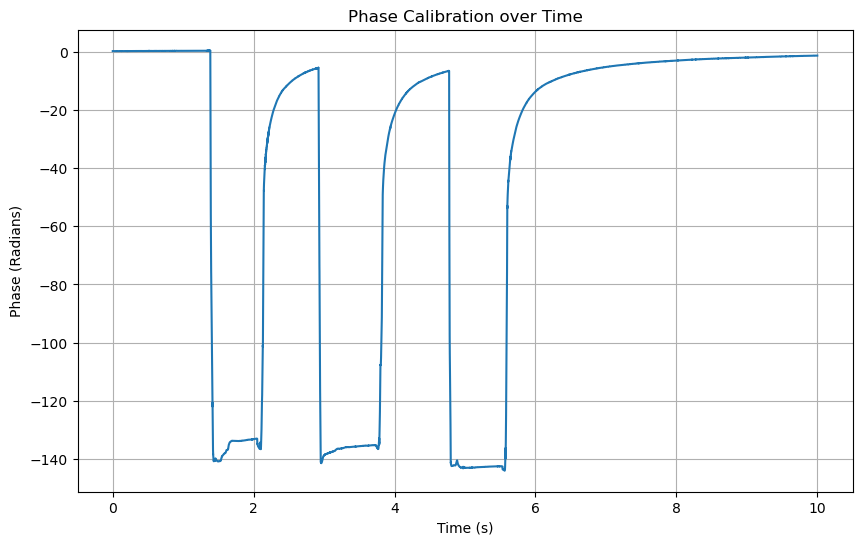

In [7]:
gain_offset_calib_6_oil = process_calibration(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\04092024\20240904_sensor6_oil_calibration_in_bad_Fs_100kHz.hdf5')

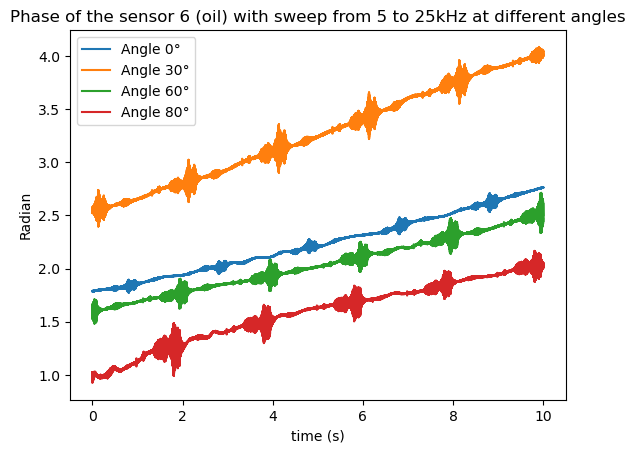

C:\Users\mugniersnm\AppData\Local\Temp\ipykernel_12124\958236309.py:391: RuntimeWarning: invalid value encountered in multiply
  pxyc = ff*cpxy/kmu
C:\Users\mugniersnm\AppData\Local\Temp\ipykernel_12124\958236309.py:391: RuntimeWarning: invalid value encountered in divide
  pxyc = ff*cpxy/kmu


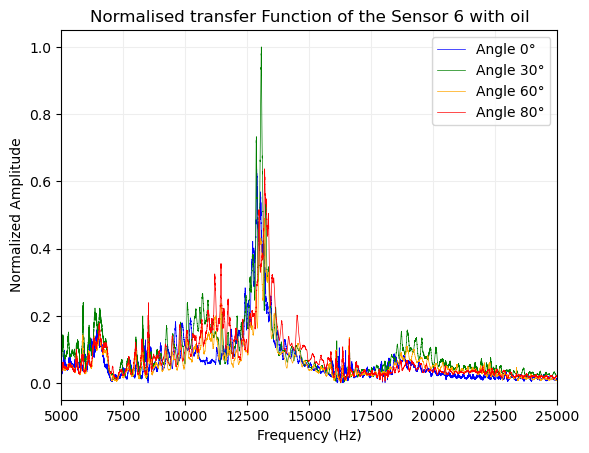

In [43]:
# ## Extraction of the data
# [trace_6o_0, metadata_6o_0] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\04092024\20240904_sensor6_oil_swp_5_25kHz_0deg_200mVpp.hdf5')
# [trace_6o_30, metadata_6o_30] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\04092024\20240904_sensor6_oil_swp_5_25kHz_30deg_500mVpp.hdf5')
# [trace_6o_60, metadata_6o_60] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\04092024\20240904_sensor6_oil_swp_5_25kHz_60deg_500mVpp.hdf5')
# [trace_6o_90, metadata_6o_90] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\04092024\20240904_sensor6_oil_swp_5_25kHz_90deg_500mVpp.hdf5')


# [trace_6o_noise, metadata_6o_noise] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_ruis_badrand.hdf5')
# ## Plotting 0°
# time = generate_time_array(0, 10, 100000)
# phase_6o_0 = get_phase(trace_6o_0, gain_offset_calib_6_oil)
# phase_6o_30 = get_phase(trace_6o_30, gain_offset_calib_6_oil)
# phase_6o_60 = get_phase(trace_6o_60, gain_offset_calib_6_oil)
# phase_6o_90 = get_phase(trace_6o_90, gain_offset_calib_6_oil)


# plt.plot(time, phase_6o_0, label="Angle 0°")
# plt.plot(time, phase_6o_30, label="Angle 30°")
# plt.plot(time, phase_6o_60, label="Angle 60°")
# plt.plot(time, phase_6o_90, label="Angle 90°")


# plt.legend()
# plt.title('Phase of the sensor 6 (oil) with sweep from 8 to 25kHz at different angles')
# plt.xlabel('time (s)')
# plt.ylabel('Radian')
# plt.show()
# ## Plotting the PSD and the transfer function

# # plot_phase_psd(phase, metadata_1D['Fs'][0], trace_1D[:,3])
# plot_transfer_functions_multiple_signals_normalised([phase_6o_0, phase_6o_30, phase_6o_60, phase_6o_90], 100000, [trace_6o_0[:,3], trace_6o_30[:,3], trace_6o_60[:,3], trace_6o_90[:,3]], ['Angle 0°', 'Angle 30°','Angle 60°','Angle 90°'], ['blue', 'green','orange','red'])

# Applying the calibration to real data

## Extraction of the data
[trace_6o_0, metadata_1D_0] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\04092024\20240904_sensor6_oil_swp_5_25kHz_0deg_200mVpp.hdf5')
[trace_6o_30, metadata_1D_30] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\04092024\20240904_sensor6_oil_swp_5_25kHz_30deg_500mVpp.hdf5')
[trace_6o_60, metadata_1D_60] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\04092024\20240904_sensor6_oil_swp_5_25kHz_60deg_500mVpp.hdf5')
[trace_6o_90, metadata_1D_90] = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\04092024\20240904_sensor6_oil_swp_5_25kHz_80deg_500mVpp.hdf5')


## Plotting 
time = generate_time_array(0, 10, 100000)
phase_6o_0 = get_phase(trace_6o_0, gain_offset_calib_6)
phase_6o_30 = get_phase(trace_6o_30, gain_offset_calib_6)
phase_6o_60 = get_phase(trace_6o_60, gain_offset_calib_6)
phase_6o_90 = get_phase(trace_6o_90, gain_offset_calib_6)

# phase_noise = get_phase(trace_1D_noise, gain_offset_calib_6)

plt.plot(time, phase_6o_0, label="Angle 0°")
plt.plot(time, phase_6o_30, label="Angle 30°")
plt.plot(time, phase_6o_60, label="Angle 60°")
plt.plot(time, phase_6o_90, label="Angle 80°")


plt.legend()
plt.title('Phase of the sensor 6 (oil) with sweep from 5 to 25kHz at different angles')
plt.xlabel('time (s)')
plt.ylabel('Radian')
plt.show()
## Plotting the transfer function

plot_transfer_functions_multiple_signals_normalised([phase_6o_0, phase_6o_30, phase_6o_60, phase_6o_90], 100000, [trace_6o_0[:,3], trace_6o_30[:,3], trace_6o_60[:,3], trace_6o_90[:,3]], ['Angle 0°', 'Angle 30°','Angle 60°','Angle 80°'], ['blue', 'green','orange','red'])


## Noise study 6 water

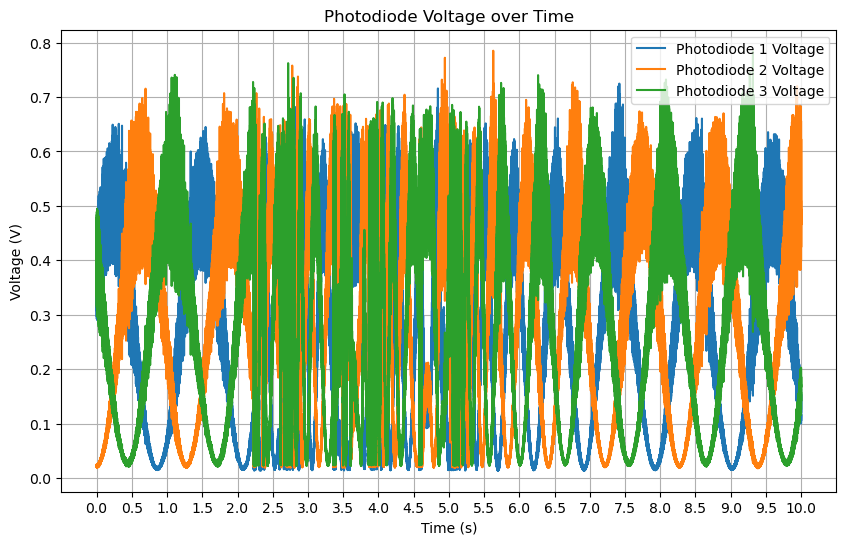

Enter the start time of the calibration window:  2.25
Enter the end time of the calibration window:  2.5




Gain and offset from #6_Calibration.hdf5 between 2.2 and 2.5 seconds:
gain:	1.07500153E+00 1.00000000E+00 1.09349646E+00
offset:	-4.37384113E-03 0.00000000E+00 5.11338443E-03


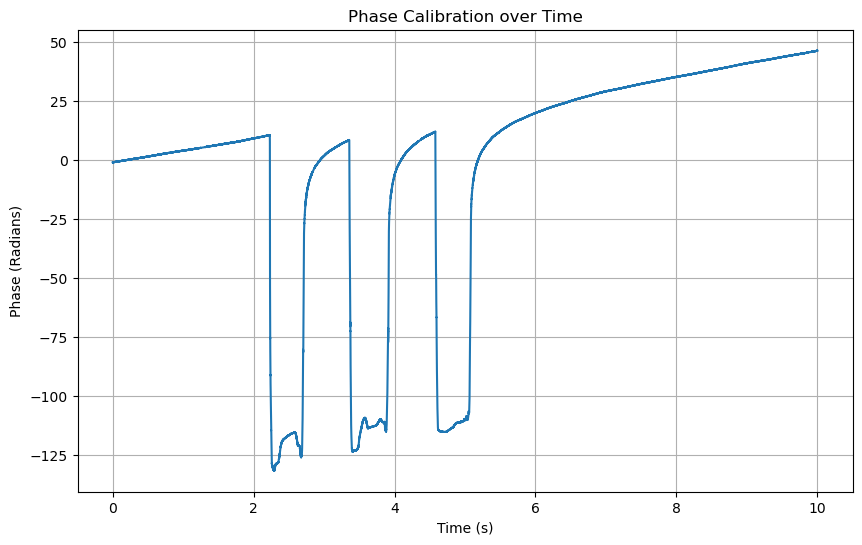

In [12]:
gain_offset_6w = process_calibration(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\#6\#6_Calibration.hdf5')

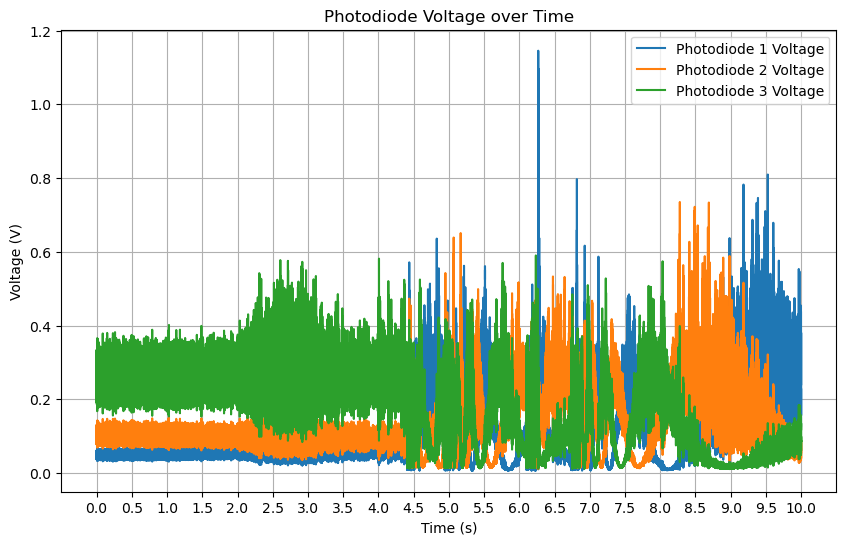

Enter the start time of the calibration window:  6.75
Enter the end time of the calibration window:  7




Gain and offset from 20240830_091026_calibratie_sensor6_inbad.hdf5 between 6.8 and 7.0 seconds:
gain:	5.21371818E-01 1.00000000E+00 8.27962774E-01
offset:	-9.55449310E-03 0.00000000E+00 -3.34163019E-03


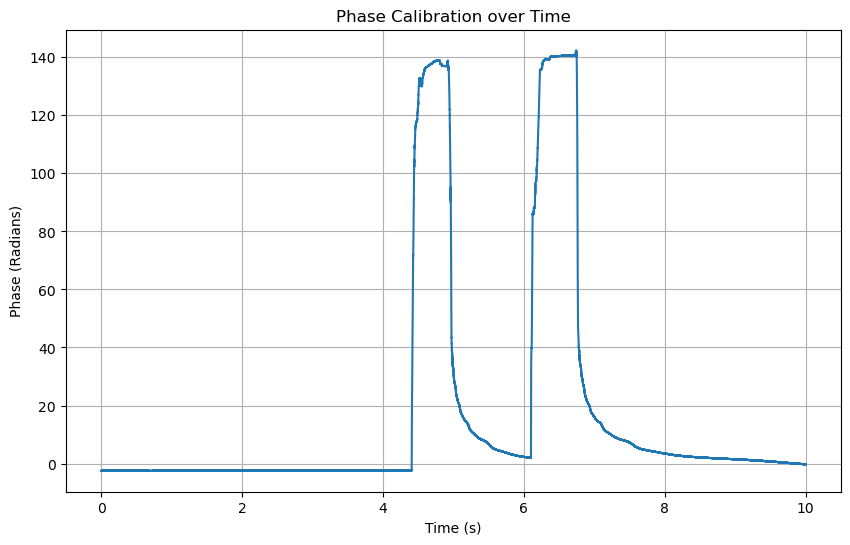

In [13]:
gain_offset_6w_int = process_calibration(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\30082024\20240830_091026_calibratie_sensor6_inbad.hdf5')

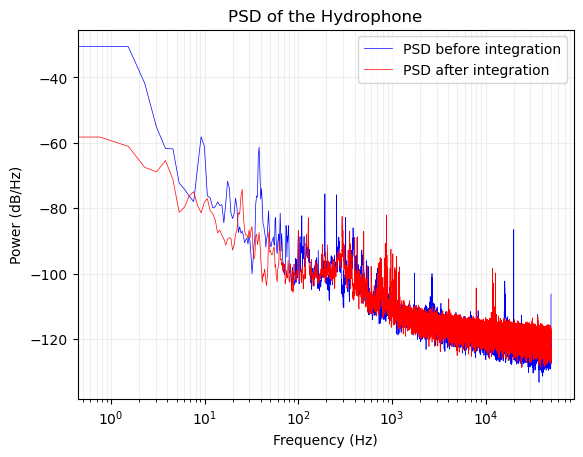

In [27]:
## Noise measurement of the Sensor 6 before integration
trace_6w, metadata_6w = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\#6\#6_Noisemeasurement.hdf5')
phase_6w = get_phase(trace_6w, gain_offset_6w)

## Noise measurement of the Sensor 6 after integration
trace_6w_int, metadata_6w_int = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\30082024\20240830_091122_ruis_sensor6_inbad.hdf5')
phase_6w_int = get_phase(trace_6w_int, gain_offset_6w_int)

## Plotting the two datasets on the same graphs
plot_comparison_psd(phase_6w, 100000, phase_6w_int, 100000)


## Noise study 1D

C:\Users\mugniersnm\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


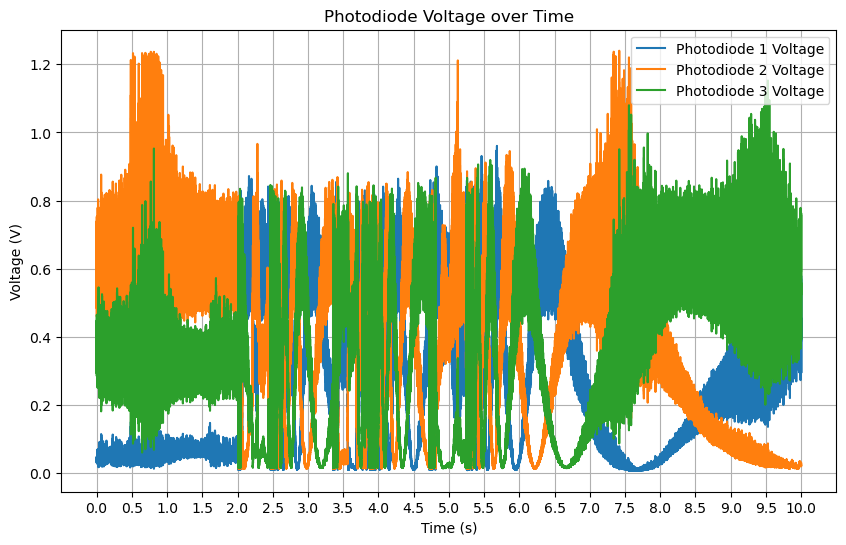

Enter the start time of the calibration window:  2.4
Enter the end time of the calibration window:  2.5




Gain and offset from #1D_Calibration.hdf5 between 2.4 and 2.5 seconds:
gain:	9.49140248E-01 1.00000000E+00 9.50764683E-01
offset:	-4.67061109E-03 0.00000000E+00 1.03579611E-03


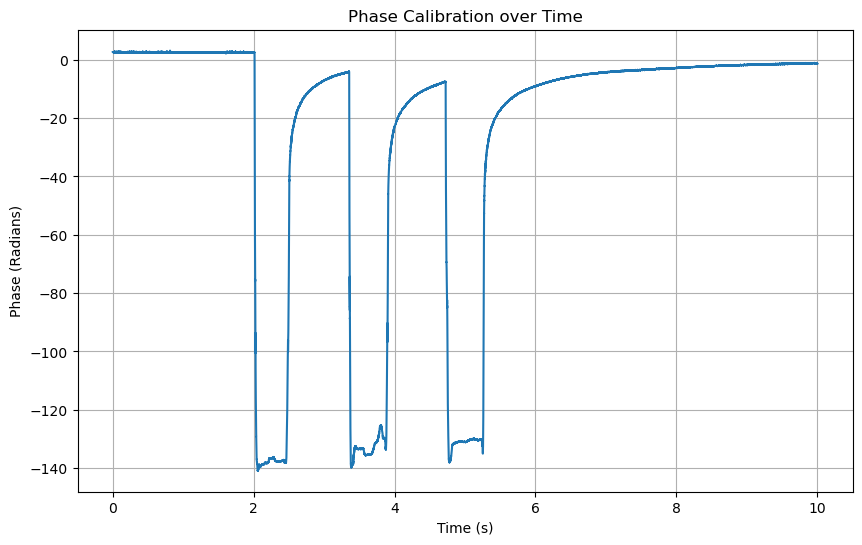

In [6]:
gain_offset_1D = process_calibration(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\#1D\#1D_Calibration.hdf5')

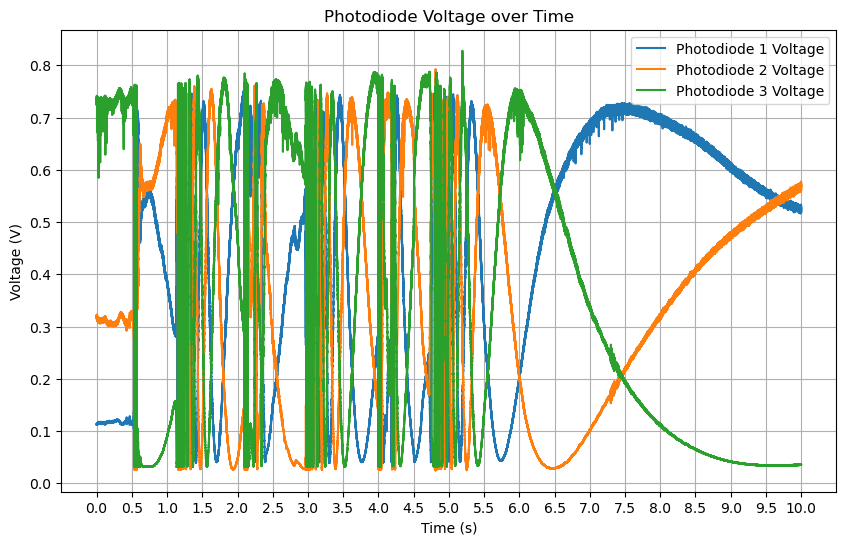

Enter the start time of the calibration window:  3
Enter the end time of the calibration window:  3.5




Gain and offset from 20240902_sensor1D_calibration_badrand.hdf5 between 3.0 and 3.5 seconds:
gain:	1.02325906E+00 1.00000000E+00 9.77481711E-01
offset:	1.40861375E-02 0.00000000E+00 4.59724548E-03


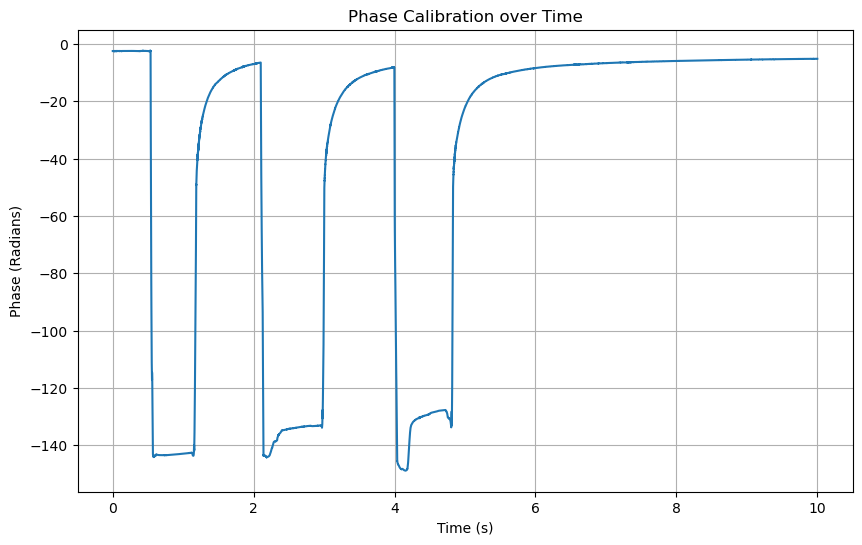

In [7]:
gain_offset_1D_int = process_calibration(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_calibration_badrand.hdf5')

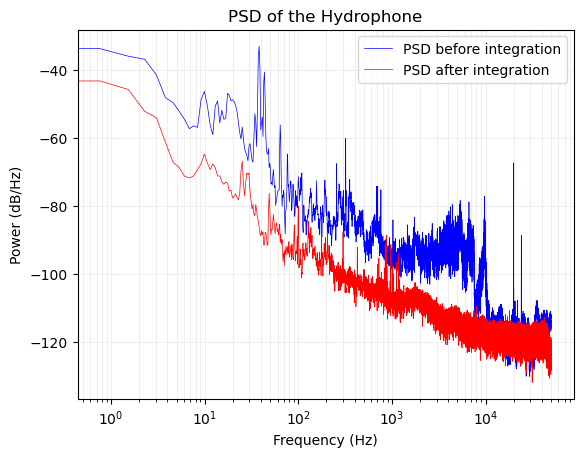

In [26]:
## Noise measurement of the Sensor 1D before integration
trace_1D, metadata_1D = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\#1D\#1D_Noisemeasurement.hdf5')
phase_1D = get_phase(trace_1D, gain_offset_1D)

## Noise measurement of the Sensor 1D after integration
trace_1D_int, metadata_1D_int = get_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\02092024\20240902_sensor1D_ruis_in_bad.hdf5')
phase_1D_int = get_phase(trace_1D_int, gain_offset_1D_int)

## Plotting the two datasets on the same graphs
plot_comparison_psd(phase_1D, 100000, phase_1D_int, 100000)


## Noise study 672

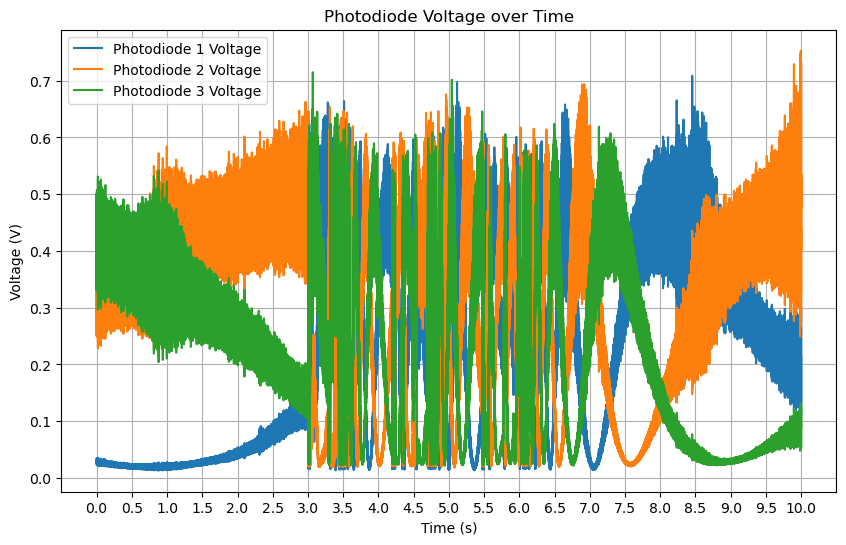

Enter the start time of the calibration window:  4.75
Enter the end time of the calibration window:  5




Gain and offset from #672_calibration.hdf5 between 4.8 and 5.0 seconds:
gain:	1.08770244E+00 1.00000000E+00 1.11744924E+00
offset:	-4.37171085E-03 0.00000000E+00 4.19163247E-03


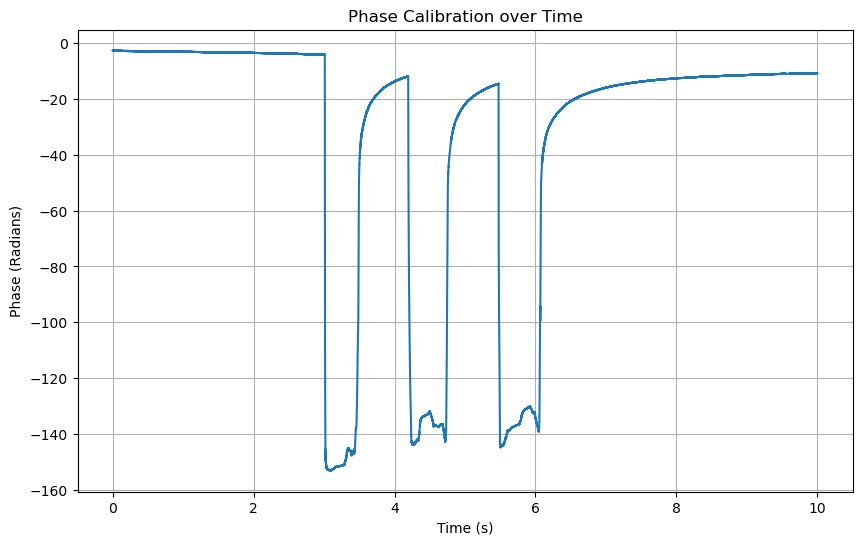

In [21]:
gain_offset_672 = process_calibration(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\#672\#672_calibration.hdf5')

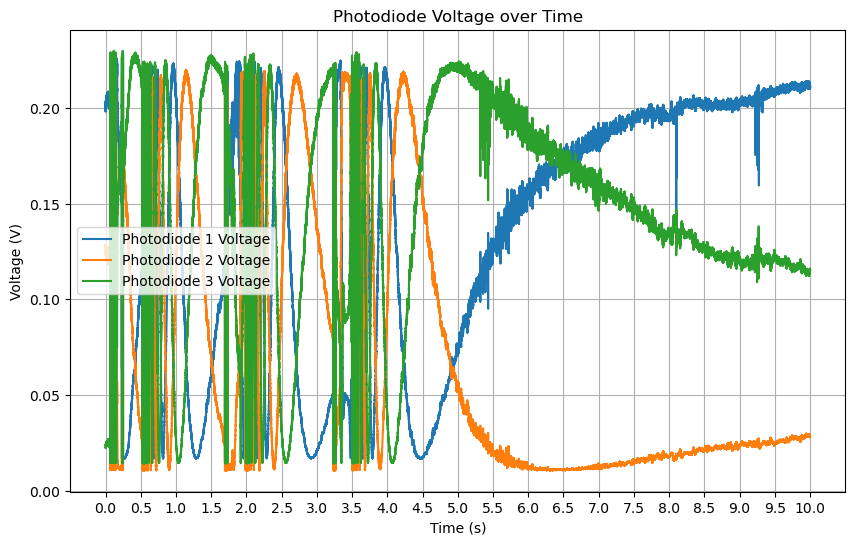

Enter the start time of the calibration window:  0.5
Enter the end time of the calibration window:  0.75




Gain and offset from 20240903_calibration_in_water_at_Fs_100kHz.hdf5 between 0.5 and 0.75 seconds:
gain:	9.98954021E-01 1.00000000E+00 9.79461845E-01
offset:	6.17530453E-03 0.00000000E+00 3.54367764E-03


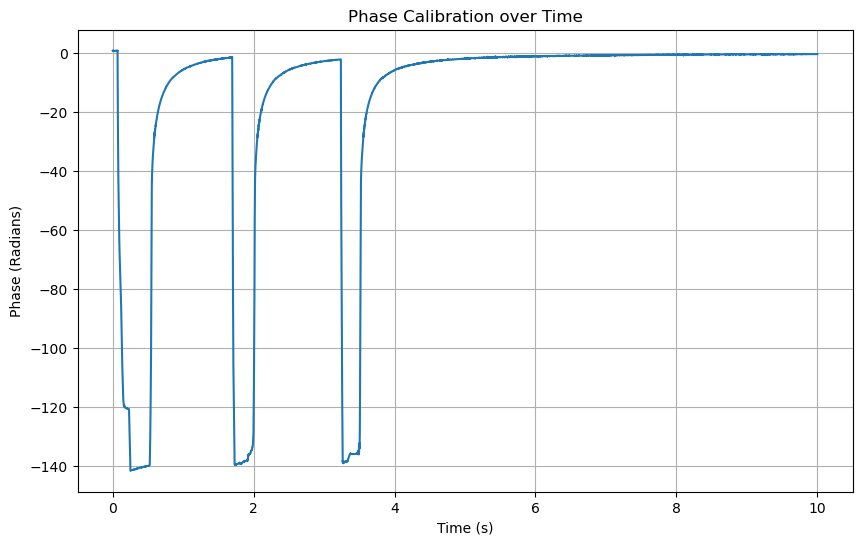

In [22]:
gain_offset_672_pool = process_calibration(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\03092024_sensor672\20240903_calibration_in_water_at_Fs_100kHz.hdf5')

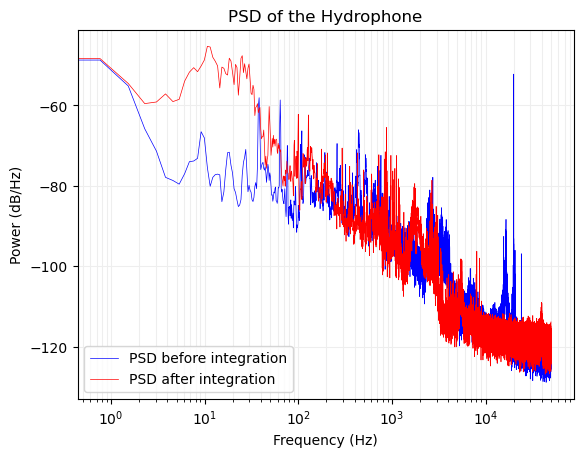

In [25]:
## Noise measurement of the Sensor 672 in the lab and in the pool
trace_672, metadata_672 = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\#672\#672_noisemeasurement.hdf5')
phase_672 = get_phase(trace_672, gain_offset_672)

## Noise measurement of the Sensor 1D after integration
trace_672_pool, metadata_672_pool = get_resampled_data(r'C:\Users\mugniersnm\Desktop\Sacha\Measurements\Measurements The Hague\03092024\20240903_sensor672_14mm_ruis_inbad.hdf5')
phase_672_pool = get_phase(trace_672_pool, gain_offset_672_pool)

## Plotting the two datasets on the same graphs
plot_comparison_psd(phase_672, 100000, phase_672_pool, 100000)